<a href="https://colab.research.google.com/github/JeffreyHernandez8656/proyectoEstadistica2/blob/main/projectestadistica2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PROYECTO DE ESTADISTICA II
#Análisis del rendimiento de jugadores de fútbol durante la temporada 2022-2023

Estudiantes:

* Nestor Jeffrey Hernandez Ruiz - Codigo: 2215108
* Leider Joanny Esteban Lozano - Codigo: 2215003

* Asignatura: Estadística II
* Docente: Elinana Bonalve
* Periodo: 2025-1

INTRODUCCION

El presente proyecto de Estadística 2 tiene como objetivo analizar un conjunto de datos correspondiente al rendimiento de jugadores de fútbol durante la temporada 2022-2023. El dataset incluye estadísticas detalladas de futbolistas que participaron en distintas ligas y competiciones, tales como goles, asistencias, minutos jugados, tarjetas, entre otros indicadores de desempeño.

Se pretende identificar patrones, realizar comparaciones entre jugadores o posiciones, y aplicar técnicas como medidas de tendencia central, dispersión, regresión, con el fin de obtener conclusiones que permitan una mejor comprensión del comportamiento y rendimiento de los futbolistas en la temporada analizada. Este estudio no solo proporciona una aplicación práctica de los conceptos vistos en clase, sino que también permite vincular la estadística con un contexto real y de interés general como lo es el fútbol.

El dataset se consiguio a partir del siguiente link


https://www.kaggle.com/datasets/vivovinco/20222023-football-player-stats

In [ ]:
#@title **Importar Librerias**
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
from scipy.stats import pearsonr
from sklearn.linear_model import LinearRegression
import scipy.stats as stats
import statsmodels.api as sm
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#@title **Conectar con Drive**
# Cargar el dataset proporcionado
file_path = '/content/drive/MyDrive/Football_players.csv'
df = pd.read_csv(file_path, sep=';')

# Mostrar las primeras filas para análisis preliminar
df.head()


,Rk,Player,Nation,Pos,Squad,Comp,Age,Born,MP,Starts,...,Off,Crs,TklW,PKwon,PKcon,OG,Recov,AerWon,AerLost,AerWon%
0,1,Brenden Aaronson,USA,MFFW,Leeds United,Premier League,22,2000,20,19,...,0.17,2.54,0.51,0.0,0.0,0.00,4.86,0.34,1.19,22.2
1,2,Yunis Abdelhamid,MAR,DF,Reims,Ligue 1,35,1987,22,22,...,0.05,0.18,1.59,0.0,0.0,0.00,6.64,2.18,1.23,64.0
2,3,Himad Abdelli,FRA,MFFW,Angers,Ligue 1,23,1999,14,8,...,0.00,1.05,1.40,0.0,0.0,0.00,8.14,0.93,1.05,47.1
3,4,Salis Abdul Samed,GHA,MF,Lens,Ligue 1,22,2000,20,20,...,0.00,0.35,0.80,0.0,0.0,0.05,6.60,0.50,0.50,50.0
4,5,Laurent Abergel,FRA,MF,Lorient,Ligue 1,30,1993,15,15,...,0.00,0.23,2.02,0.0,0.0,0.00,6.51,0.31,0.39,44.4


In [ ]:
#@title **Limpieza y organización del dataset**
# Ver dimensiones y tipos de datos
df_info = df.info()
# Verificar valores nulos por columna
missing_values = df.isnull().sum().sort_values(ascending=False)
# Contar duplicados
duplicates_count = df.duplicated().sum()
# Mostrar resultados clave
df.shape, missing_values.head(10), duplicates_count

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2689 entries, 0 to 2688
Columns: 124 entries, Rk to AerWon%
dtypes: float64(112), int64(7), object(5)
memory usage: 2.5+ MB


((2689, 124),
 Nation    1
 Rk        0
 Player    0
 Pos       0
 Squad     0
 Comp      0
 Age       0
 Born      0
 MP        0
 Starts    0
 dtype: int64,
 np.int64(0))

Se realiza un diagnóstico inicial del conjunto de datos con el fin de conocer su estructura y calidad, identificando la cantidad de registros y columnas disponibles, así como los tipos de datos que contiene cada variable. Se examinan los valores faltantes por columna, ordenándolos de mayor a menor para facilitar su análisis, y se contabilizan los registros duplicados que podrían afectar la integridad del análisis.

In [ ]:
#@title **Limpieza automatizada**
# Copia del dataframe para trabajo limpio
df_clean = df.copy()
# Quitar columnas no numéricas innecesarias para análisis estadístico
drop_cols = ['Rk', 'Player', 'Squad', 'Nation', 'Comp', 'Pos']
df_clean = df_clean.drop(columns=drop_cols)
# Convertir porcentajes en 'AerWon%'
if df['AerWon%'].dtype == 'object':
    df_clean['AerWon%'] = df['AerWon%'].str.replace('%', '').astype(float)

# Confirmar que solo hay columnas numéricas ahora
numeric_cols = df_clean.select_dtypes(include=['number']).columns.tolist()
# Verificar valores faltantes tras limpieza
missing_after_cleaning = df_clean.isnull().sum().sum()
# Mostrar columnas seleccionadas para análisis
numeric_cols[:10], len(numeric_cols), missing_after_cleaning

(['Age',
  'Born',
  'MP',
  'Starts',
  'Min',
  '90s',
  'Goals',
  'Shots',
  'SoT',
  'SoT%'],
 118,
 np.int64(0))

Se genera una copia del conjunto de datos original para trabajar exclusivamente con variables numéricas relevantes para el análisis estadístico. Se eliminan columnas cualitativas como nombres, equipos y nacionalidades, y se transforman porcentajes en valores numéricos eliminando símbolos como el “%”.

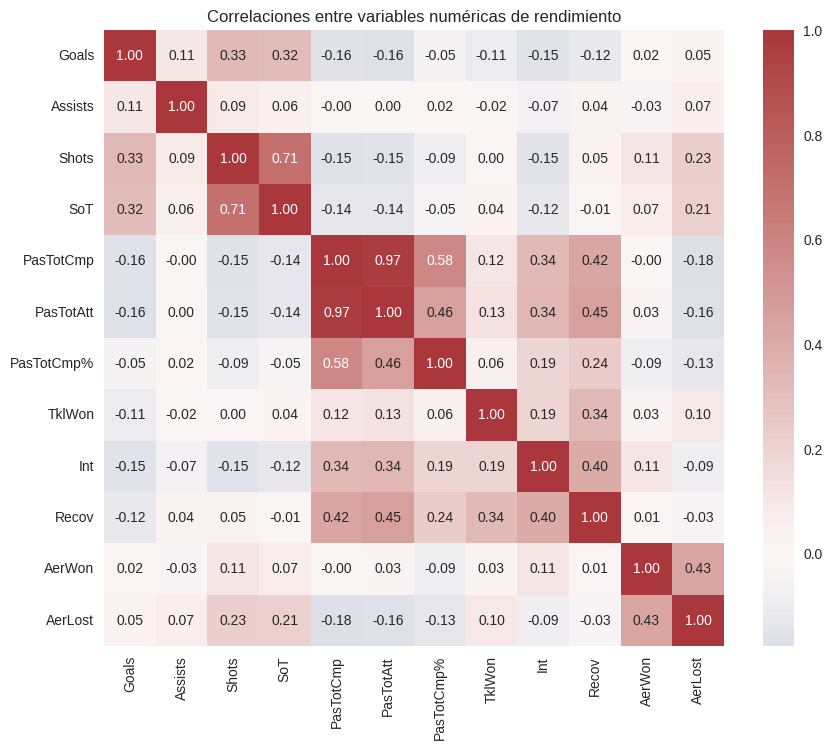

In [ ]:
# Seleccionar un subconjunto de columnas numéricas relevantes
selected_columns = [
    'Goals', 'Assists', 'Shots', 'SoT', 'PasTotCmp', 'PasTotAtt', 'PasTotCmp%',
    'TklWon', 'Int', 'Recov', 'AerWon', 'AerLost'
]
# Filtrar el dataset para incluir solo las columnas seleccionadas
numeric_df = df[selected_columns].select_dtypes(include=['int64', 'float64'])
# Calcular la matriz de correlación
corr = numeric_df.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="vlag", center=0)
plt.title("Correlaciones entre variables numéricas de rendimiento")
plt.show()

Se selecciona un subconjunto de variables numéricas clave relacionadas con el rendimiento de los futbolistas, como goles, asistencias, disparos, pases, recuperaciones e intervenciones defensivas. A partir de estas columnas, se calcula una matriz de correlación que permite identificar el grado de relación entre ellas. Esta matriz se visualiza mediante un mapa de calor (heatmap), lo que facilita detectar asociaciones positivas o negativas entre distintas métricas de desempeño.

In [ ]:
#@title **Instanciar Variables**
x = df['Min'].to_numpy()  # Minutos jugados
y = df['Goals'].to_numpy()  # Goles marcados

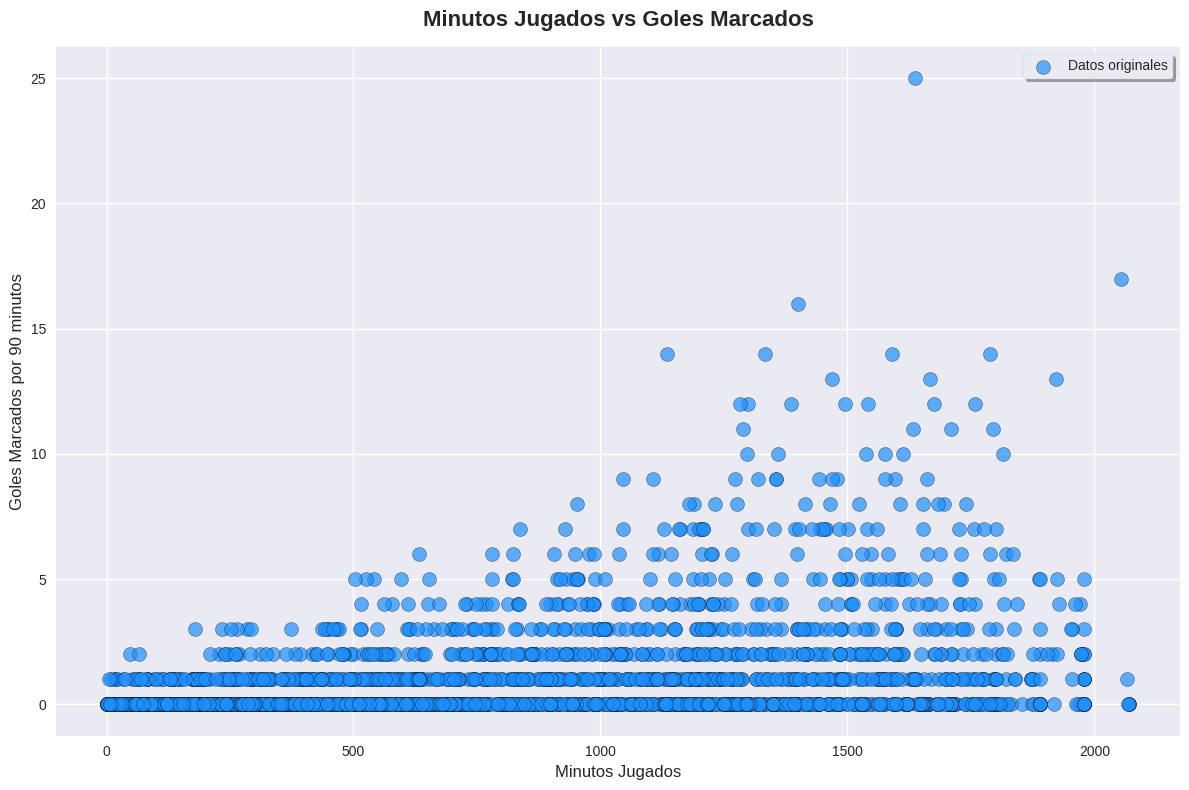

In [ ]:
#@title **Grafca De Dispersion**
# Estilo del gráfico
sns.set_style("whitegrid")
plt.style.use('seaborn-v0_8')

plt.figure(figsize=(12, 8))

# Gráfico de dispersión con línea de regresión
plt.scatter(x, y, color='dodgerblue', s=100, edgecolor='black', alpha=0.7, label='Datos originales')
plt.title('Minutos Jugados vs Goles Marcados', fontsize=16, fontweight='bold', pad=15)
plt.xlabel('Minutos Jugados', fontsize=12)
plt.ylabel('Goles Marcados por 90 minutos', fontsize=12)

plt.legend(fontsize=10, loc='best', frameon=True, shadow=True)
plt.tight_layout()
plt.savefig('scatter_minutes_goals.png')
plt.show()

Análisis de la Gráfica de Dispersión: Minutos Jugados vs. Goles Marcados por 90 minutos
Observaciones Clave:
1. Alta concentración en cero goles:
La mayoría de los jugadores registra pocos o ningún gol por 90 minutos, incluso con muchos minutos jugados.

2. Valores altos con pocos minutos:
Algunos jugadores con pocos minutos tienen tasas de goles muy altas, lo que puede distorsionar la interpretación real de su rendimiento.

3. Rendimiento más estable con más minutos:
Los jugadores con más tiempo en cancha tienden a mostrar tasas de gol más consistentes y realistas.

4. Sin relación lineal clara:
No se observa una correlación directa entre minutos jugados y goles por 90 minutos; otros factores parecen influir más.

5. Outliers presentes:
Existen valores extremos (más de 10 goles/90 min) que probablemente corresponden a casos atípicos con poca participación.

In [ ]:
#@title **Prueba De Regresión Completa**
def regresion_completa(x, y, alpha=0.05, z=None, desv_abajo=1, desv_arriba=1,
                      limite_inf=None, limite_sup=None):
    # Validación de datos de entrada
    n = len(x)
    if n != len(y): raise ValueError("x e y deben tener la misma longitud")
    if n <= 2: raise ValueError("Se necesitan al menos 3 puntos para regresión")

    # 1. Cálculos básicos de estadísticos
    x_barra, y_barra = np.mean(x), np.mean(y)  # Medias de x e y
    sum_x, sum_y = np.sum(x), np.sum(y)        # Sumatorias de x e y
    sum_xy = np.sum(x * y)                     # Sumatoria de productos xy
    sum_x2, sum_y2 = np.sum(x**2), np.sum(y**2) # Sumatorias de cuadrados

    # Sumas de cuadrados para la regresión
    SXX = sum_x2 - sum_x**2 / n  # Suma de cuadrados de x
    SXY = sum_xy - sum_x * sum_y / n  # Suma de productos cruzados
    SYY = sum_y2 - sum_y**2 / n  # Suma de cuadrados de y

    # 2. Cálculo de coeficientes de regresión (B0: intercepto, B1: pendiente)
    B1 = SXY / SXX  # Pendiente
    B0 = y_barra - B1 * x_barra  # Intercepto
    y_estimados = B0 + B1 * x  # Valores estimados por el modelo

    # 3. Cálculo del error estándar
    SSE = np.sum((y - y_estimados)**2)  # Suma de cuadrados del error
    sigma2 = SSE / (n - 2)  # Varianza del error
    sigma = np.sqrt(sigma2)  # Desviación estándar del error

    # 4. Varianzas y errores estándar de los coeficientes
    var_B1 = sigma2 / SXX  # Varianza de la pendiente
    std_B1 = np.sqrt(var_B1)  # Error estándar de la pendiente
    var_B0 = sigma2 * (1/n + x_barra**2/SXX)  # Varianza del intercepto
    std_B0 = np.sqrt(var_B0)  # Error estándar del intercepto
    cov_B0_B1 = -sigma2 * x_barra / SXX  # Covarianza entre coeficientes

    # 5. Intervalo de confianza para la pendiente (β₁)
    t_critico = stats.t.ppf(1 - alpha/2, n-2)  # Valor crítico t
    ic_B1_inf, ic_B1_sup = B1 - t_critico * std_B1, B1 + t_critico * std_B1

    # 6. Predicción para un valor z específico
    resultados_z = {}
    if z is not None:
        y_estimado = B0 + B1 * z  # Valor predicho para z

        # Determinar límites para cálculo de probabilidad
        if limite_inf is not None or limite_sup is not None:
            lim_inf = limite_inf if limite_inf is not None else -np.inf
            lim_sup = limite_sup if limite_sup is not None else np.inf
            tipo = "absolutos"
        else:
            lim_inf = y_estimado - desv_abajo * sigma
            lim_sup = y_estimado + desv_arriba * sigma
            tipo = f"{desv_abajo}σ abajo y {desv_arriba}σ arriba"

        # Calcular probabilidad dentro de los límites
        prob = stats.norm.cdf(lim_sup, loc=y_estimado, scale=sigma) - \
               stats.norm.cdf(lim_inf, loc=y_estimado, scale=sigma)

        # Intervalo de predicción
        error_pred = sigma * np.sqrt(1 + 1/n + (z - x_barra)**2/SXX)
        pred_inf = y_estimado - t_critico * error_pred
        pred_sup = y_estimado + t_critico * error_pred

        resultados_z = {
            'z': z, 'y_estimado': y_estimado,
            'intervalo_probabilidad': (lim_inf, lim_sup),
            'tipo_intervalo_prob': tipo, 'probabilidad': prob,
            'intervalo_prediccion': (pred_inf, pred_sup)
        }

    # 7. Compilar todos los resultados
    resultados = {
        'B0': B0, 'B1': B1, 'sigma': sigma, 'sigma2': sigma2, 'SSE': SSE,
        'SXX': SXX, 'SXY': SXY, 'SYY': SYY, 'r': SXY / np.sqrt(SXX * SYY),
        'x_barra': x_barra, 'y_barra': y_barra, 'ic_B1': (ic_B1_inf, ic_B1_sup),
        'std_B1': std_B1, 'var_B0': var_B0, 'std_B0': std_B0,
        'cov_B0_B1': cov_B0_B1, 'y_estimados': y_estimados,
    }
    if resultados_z: resultados.update(resultados_z)

    # 8. Imprimir os resultados
    print("\n----------- RESUMEN DE RESULTADOS -----------")
    print(f"Modelo de regresión: Goles = {B0:.4f} + {B1:.4f} * Minutos")
    print(f"\nSumas de cuadrados:")
    print(f"SXX (Suma de cuadrados de minutos): {SXX:.4f}")
    print(f"SXY (Suma de productos cruzados): {SXY:.4f}")
    print(f"SYY (Suma de cuadrados de goles): {SYY:.4f}")
    print(f"\nEstimación de error:")
    print(f"Suma de cuadrados del error (SSE): {SSE:.4f}")
    print(f"Varianza del error (σ²): {sigma2:.4f}")
    print(f"Desviación estándar del error (σ): {sigma:.4f}")
    print(f"\nCoeficiente de correlación (r): {resultados['r']:.4f}")

    print(f"\nPropiedades de los coeficientes:")
    print(f"B0 (Intercepto):")
    print(f"  Varianza: {var_B0:.6f}")
    print(f"  Error estándar: {std_B0:.6f}")
    print(f"B1 (Pendiente):")
    print(f"  Varianza: {var_B1:.6f}")
    print(f"  Error estándar: {std_B1:.6f}")
    print(f"Covarianza(B0, B1): {cov_B0_B1:.6f}")

    print(f"\nIntervalo de confianza para β₁ ({(1-alpha)*100}%):")
    print(f"  Límite inferior: {ic_B1_inf:.6f}")
    print(f"  Límite superior: {ic_B1_sup:.6f}")
    print(f"  Error estándar de β₁: {std_B1:.6f}")

    if 'y_estimado' in resultados:
        print(f"\nPredicción para Minutos = {z}:")
        print(f"  Goles estimados: {y_estimado:.4f}")
        print(f"  Intervalo de probabilidad ({tipo}): ({lim_inf:.4f}, {lim_sup:.4f})")
        print(f"  Probabilidad: {prob*100:.2f}%")
        print(f"  Intervalo de predicción (95.0%): ({pred_inf:.4f}, {pred_sup:.4f})")

    return resultados
# Ejecutar la regresión con z=1000 (minutos jugados)
resultados = regresion_completa(x, y, alpha=0.05, z=1000, desv_abajo=1, desv_arriba=1)


----------- RESUMEN DE RESULTADOS -----------
Modelo de regresión: Goles = 0.0478 + 0.0013 * Minutos

Sumas de cuadrados:
SXX (Suma de cuadrados de minutos): 939166835.8193
SXY (Suma de productos cruzados): 1209993.6188
SYY (Suma de cuadrados de goles): 10899.9636

Estimación de error:
Suma de cuadrados del error (SSE): 9341.0451
Varianza del error (σ²): 3.4764
Desviación estándar del error (σ): 1.8645

Coeficiente de correlación (r): 0.3782

Propiedades de los coeficientes:
B0 (Intercepto):
  Varianza: 0.003433
  Error estándar: 0.058595
B1 (Pendiente):
  Varianza: 0.000000
  Error estándar: 0.000061
Covarianza(B0, B1): -0.000003

Intervalo de confianza para β₁ (95.0%):
  Límite inferior: 0.001169
  Límite superior: 0.001408
  Error estándar de β₁: 0.000061

Predicción para Minutos = 1000:
  Goles estimados: 1.3361
  Intervalo de probabilidad (1σ abajo y 1σ arriba): (-0.5284, 3.2007)
  Probabilidad: 68.27%
  Intervalo de predicción (95.0%): (-2.3207, 4.9930)


In [ ]:
#@title **Ley de los grandes Numeros**
#Filtrar jugadores con más de 5 partidos jugados para datos más significativos
df = df[df['MP'] > 5]  # MP = Partidos jugados

def law_of_large_numbers(data, num_trials):
    """Demuestra la Ley de los Grandes Números"""
    true_mean = np.mean(data)  # Media real de los datos
    sample_means = []  # Aquí guardaremos las medias muestrales

    for i in range(1, num_trials + 1):
        sample = np.random.choice(data, size=i, replace=True)  # Muestra aleatoria
        sample_means.append(np.mean(sample))  # Calcula y guarda la media

    return np.array(sample_means), true_mean  # Devuelve resultados

# Ejecutamos con 1000 muestras de minutos jugados
sample_means, true_mean = law_of_large_numbers(df['Min'].to_numpy(), 1000)

print(f"Media real (minutos jugados): {true_mean:.2f}")

Media real (minutos jugados): 998.84


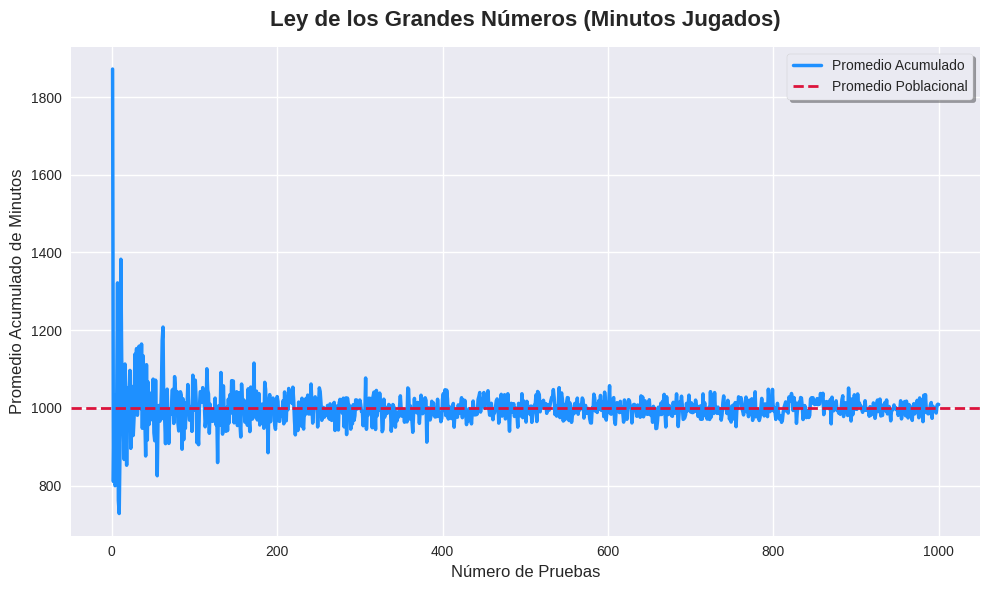

Media Poblacional (Minutos jugados): 998.84


In [ ]:
#@title **Grafica de la Ley de los grandes Numeros**
# Ejecutar la función con la columna 'Min' (minutos jugados)
num_trials = 1000  # Número de experimentos a realizar
cumulative_averages, population_mean = law_of_large_numbers(df['Min'].to_numpy(), num_trials)

# Gráfico: Ley de los Grandes Números
plt.figure(figsize=(10, 6))

plt.plot(range(1, num_trials + 1), cumulative_averages,
         color='dodgerblue', linewidth=2.5, label='Promedio Acumulado')
plt.axhline(y=population_mean, color='crimson', linestyle='--',
            linewidth=2, label='Promedio Poblacional')
plt.title('Ley de los Grandes Números (Minutos Jugados)',
          fontsize=16, fontweight='bold', pad=15)
plt.xlabel('Número de Pruebas', fontsize=12)
plt.ylabel('Promedio Acumulado de Minutos', fontsize=12)
plt.legend(fontsize=10, loc='best', frameon=True, shadow=True)
plt.tight_layout()
plt.savefig('law_of_large_numbers_minutes.png')
plt.show()

print(f"Media Poblacional (Minutos jugados): {population_mean:.2f}")

Análisis de la Gráfica: Ley de los Grandes Números (Minutos Jugados)
Observaciones Clave:
1. Alta variabilidad inicial:
Al comienzo, el promedio acumulado de minutos fluctúa fuertemente debido al bajo número de observaciones.

2. Convergencia progresiva:
A medida que aumenta el número de pruebas, el promedio acumulado se va estabilizando.

3. Aproximación al promedio poblacional:
El promedio acumulado converge hacia la línea roja (promedio poblacional), confirmando la Ley de los Grandes Números.

4. Reducción de la variabilidad:
Las oscilaciones del promedio disminuyen con más datos, mostrando mayor consistencia en la estimación.

5. Evidencia de estabilidad estadística:
La gráfica demuestra cómo un mayor tamaño de muestra mejora la precisión del promedio estimado.

In [ ]:
#@title **Filtrar jugadores con más de 5 partidos jugados para datos más significativos**
df = df[df['MP'] > 5]  # Filtramos solo jugadores con más de 5 partidos

def law_of_large_numbers(data, num_trials):
    population_mean = np.mean(data)  # Calculamos la media de todos los datos
    cumulative_averages = []  # Lista para almacenar los promedios muestrales

    for i in range(1, num_trials + 1):
        # Tomamos una muestra aleatoria de tamaño i (con reemplazo)
        sample = np.random.choice(data, size=i, replace=True)
        cumulative_averages.append(np.mean(sample))

    return np.array(cumulative_averages), population_mean

# Aplicamos la función a la columna de Goles
num_trials = 1000  # Número de muestras a generar
cumulative_averages_goals, population_mean_goals = law_of_large_numbers(
    df['Goals'].to_numpy(),
    num_trials
)

print(f"Media Poblacional (Goles marcados): {population_mean_goals:.2f}")

Media Poblacional (Goles marcados): 1.37



=== Resultados del Teorema del Límite Central ===

Minutos Jugados:
• Media poblacional (μ): 998.84
• Desviación poblacional (σ): 509.35
• Desviación de medias muestrales (σ/√n): 93.50
• Teórico σ/√n: 92.99

Goles Marcados:
• Media poblacional (μ): 1.37
• Desviación poblacional (σ): 2.25
• Desviación de medias muestrales (σ/√n): 0.44
• Teórico σ/√n: 0.41


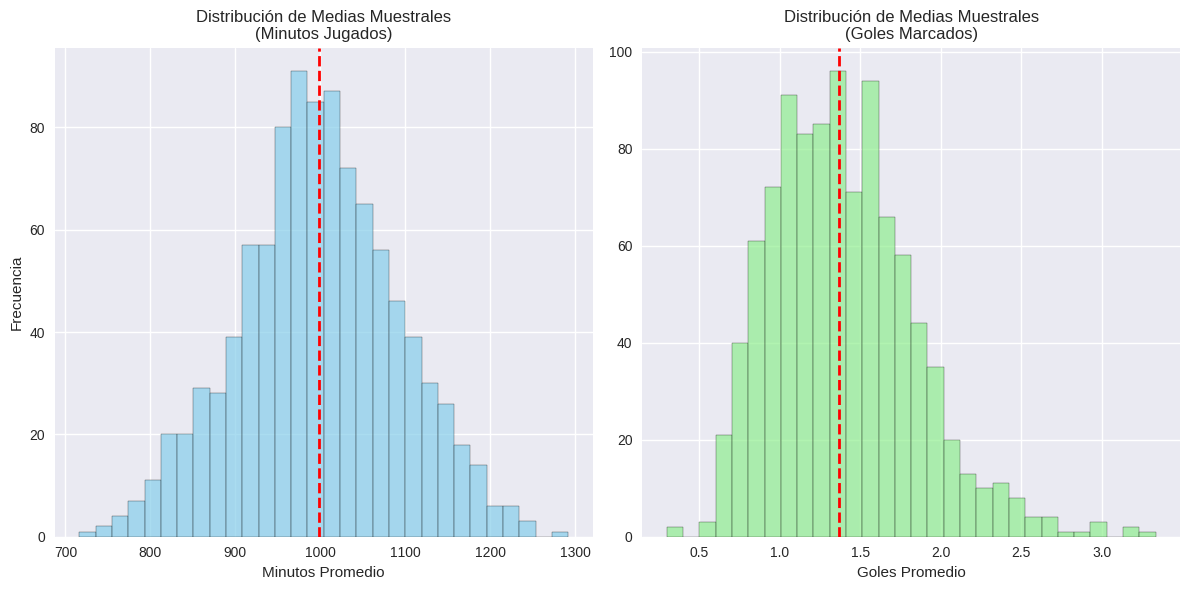

In [ ]:
#@title **Teorema del Límite Central**
def central_limit_theorem(data, sample_size, num_samples):
    population_mean = np.mean(data)  # Media poblacional
    population_std = np.std(data)  # Desviación estándar poblacional
    sample_means = []

    # Generamos múltiples muestras y calculamos sus medias
    for _ in range(num_samples):
        sample = np.random.choice(data, size=sample_size, replace=True)
        sample_means.append(np.mean(sample))

    sample_means = np.array(sample_means)
    sample_std = np.std(sample_means)  # Desviación estándar de las medias muestrales

    return sample_means, population_mean, population_std, sample_std

# Configuración de parámetros para el análisis
SAMPLE_SIZE = 30  # Tamaño de cada muestra
NUM_SAMPLES = 1000  # Cantidad de muestras a generar
# Aplicamos el TLC a minutos jugados
sample_means_minutes, pop_mean_min, pop_std_min, sample_std_min = central_limit_theorem(
    df['Min'].to_numpy(), SAMPLE_SIZE, NUM_SAMPLES)
# Aplicamos el TLC a goles marcados
sample_means_goals, pop_mean_goals, pop_std_goals, sample_std_goals = central_limit_theorem(
    df['Goals'].to_numpy(), SAMPLE_SIZE, NUM_SAMPLES)

print("\n=== Resultados del Teorema del Límite Central ===")
print(f"\nMinutos Jugados:")
print(f"• Media poblacional (μ): {pop_mean_min:.2f}")
print(f"• Desviación poblacional (σ): {pop_std_min:.2f}")
print(f"• Desviación de medias muestrales (σ/√n): {sample_std_min:.2f}")
print(f"• Teórico σ/√n: {pop_std_min/np.sqrt(SAMPLE_SIZE):.2f}")

print(f"\nGoles Marcados:")
print(f"• Media poblacional (μ): {pop_mean_goals:.2f}")
print(f"• Desviación poblacional (σ): {pop_std_goals:.2f}")
print(f"• Desviación de medias muestrales (σ/√n): {sample_std_goals:.2f}")
print(f"• Teórico σ/√n: {pop_std_goals/np.sqrt(SAMPLE_SIZE):.2f}")

plt.figure(figsize=(12, 6))

# Histograma para minutos
plt.subplot(1, 2, 1)
plt.hist(sample_means_minutes, bins=30, color='skyblue', edgecolor='black', alpha=0.7)
plt.axvline(pop_mean_min, color='red', linestyle='dashed', linewidth=2)
plt.title('Distribución de Medias Muestrales\n(Minutos Jugados)')
plt.xlabel('Minutos Promedio')
plt.ylabel('Frecuencia')

# Histograma para goles
plt.subplot(1, 2, 2)
plt.hist(sample_means_goals, bins=30, color='lightgreen', edgecolor='black', alpha=0.7)
plt.axvline(pop_mean_goals, color='red', linestyle='dashed', linewidth=2)
plt.title('Distribución de Medias Muestrales\n(Goles Marcados)')
plt.xlabel('Goles Promedio')

plt.tight_layout()
plt.show()

Análisis de la Gráfica: Distribución de Medias Muestrales (Minutos Jugados y Goles Marcados)
Observaciones Clave:
1. Forma aproximadamente normal:
Ambas distribuciones tienen forma de campana, lo que respalda el Teorema Central del Límite: las medias muestrales tienden a seguir una distribución normal, incluso si los datos originales no lo son.

2. Medias centradas en la población:
Las líneas rojas indican el promedio poblacional, y ambas distribuciones están centradas alrededor de estos valores, lo que muestra que las muestras son representativas.

3. Menor dispersión en minutos jugados:
La distribución de minutos promedio es más simétrica y concentrada, sugiriendo menor variabilidad entre muestras en comparación con los goles.

4. Mayor asimetría en goles marcados:
La distribución de goles promedio es un poco sesgada a la derecha, lo que indica que algunos jugadores con muchos goles afectan más la media.

5. Consistencia muestral:
Ambas gráficas muestran que al tomar múltiples muestras aleatorias, los promedios tienden a agruparse cerca del verdadero promedio poblacional.

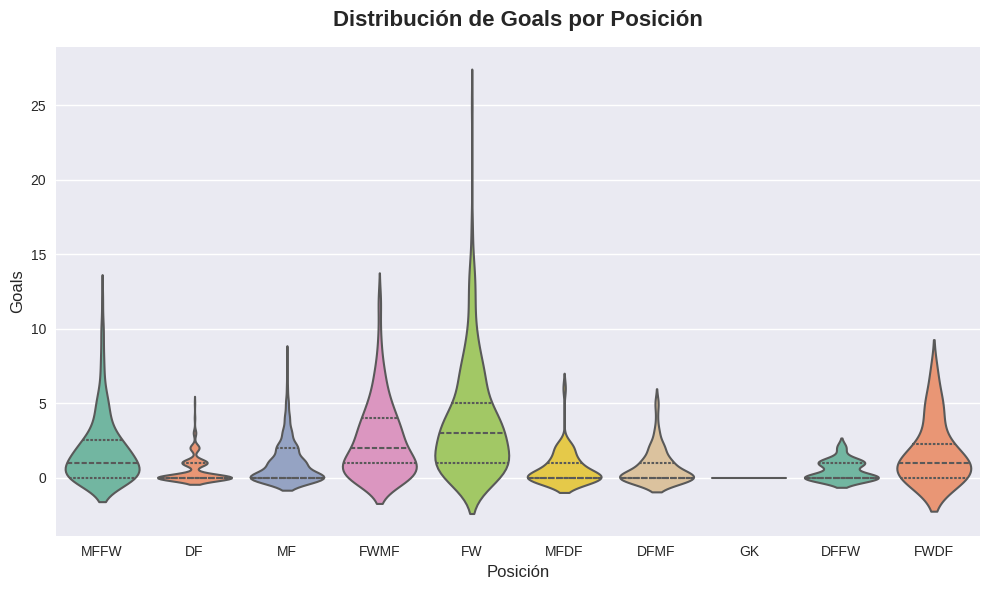

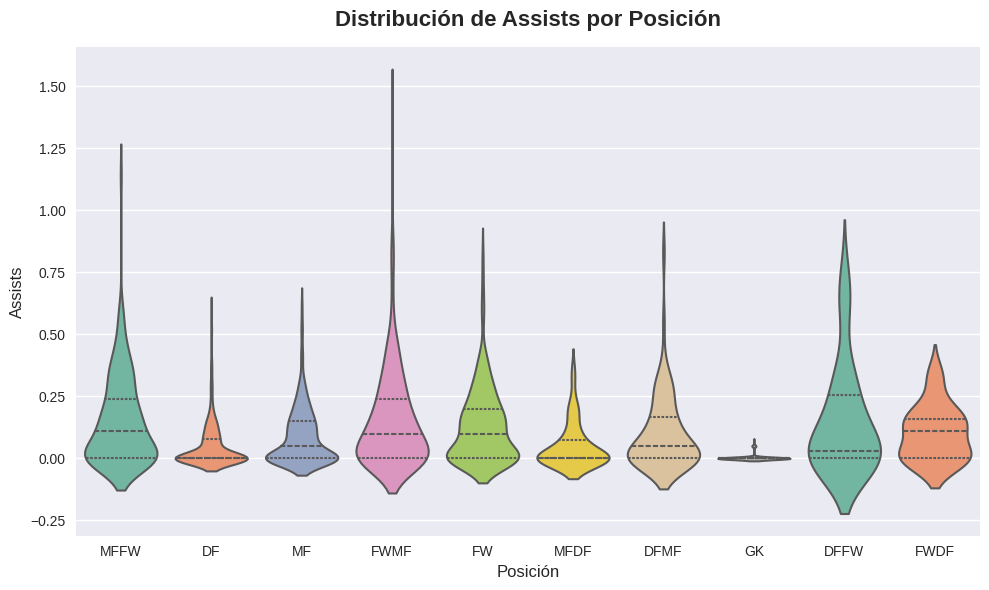

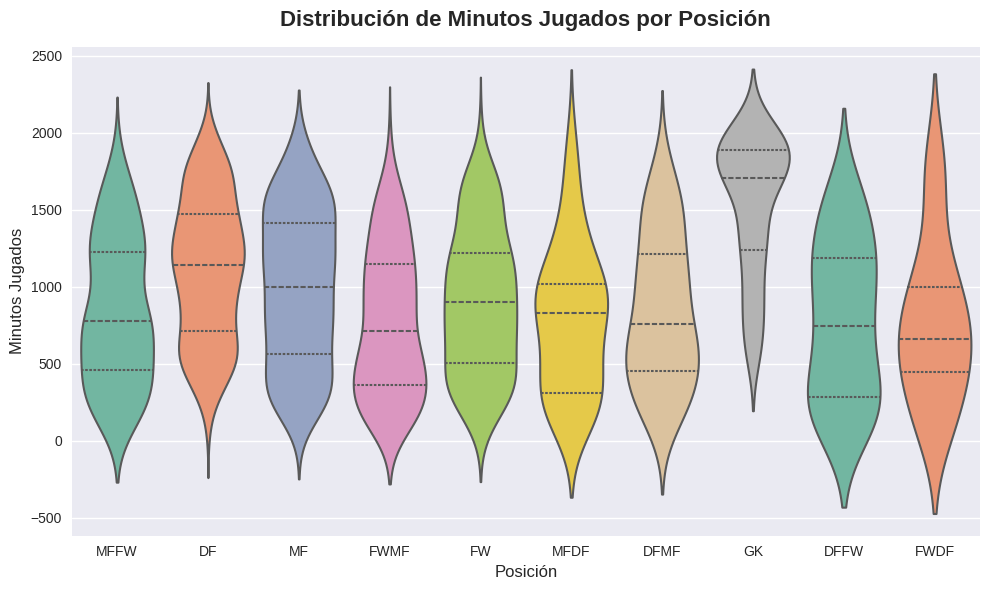

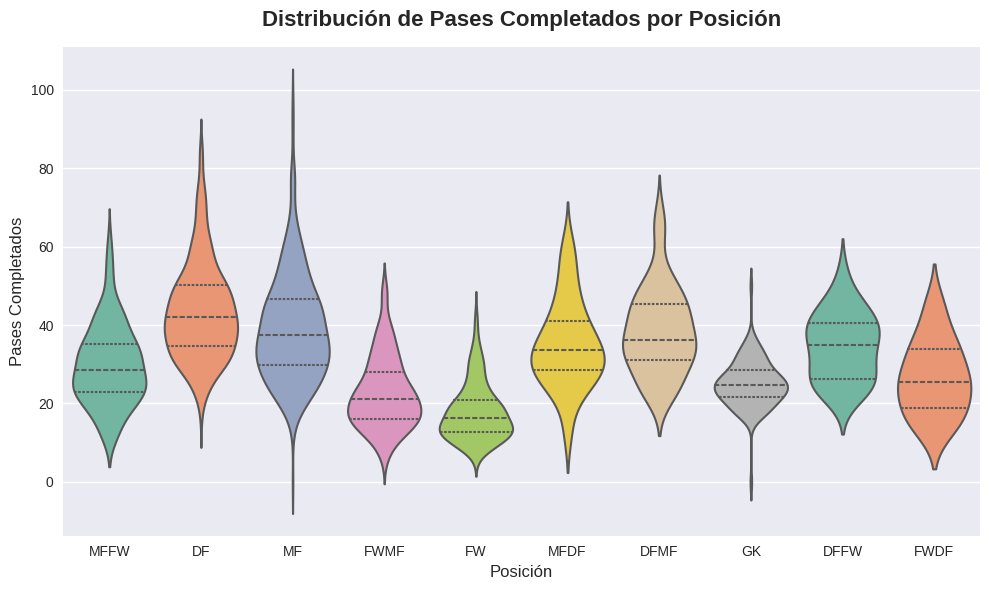

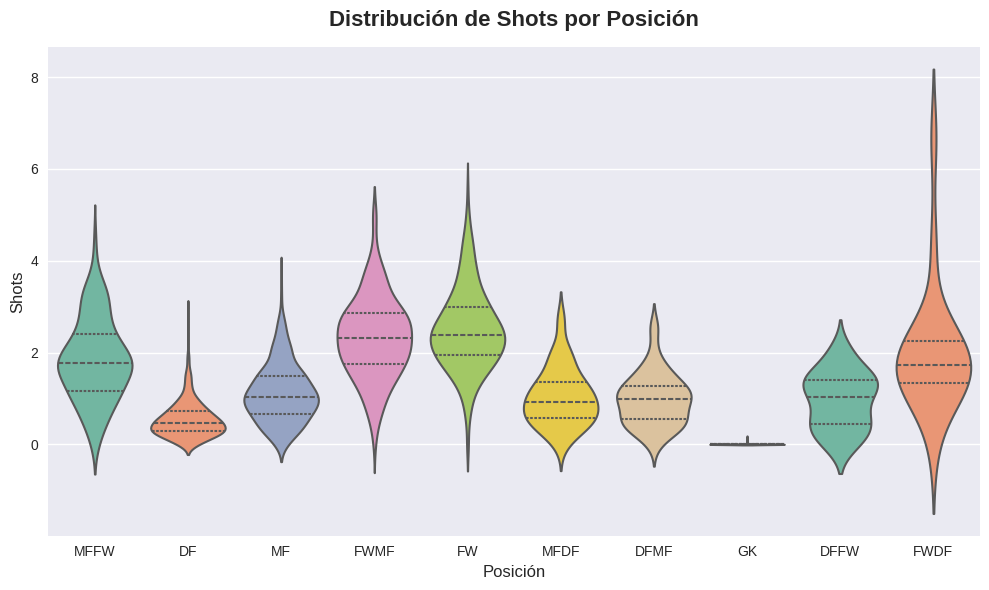

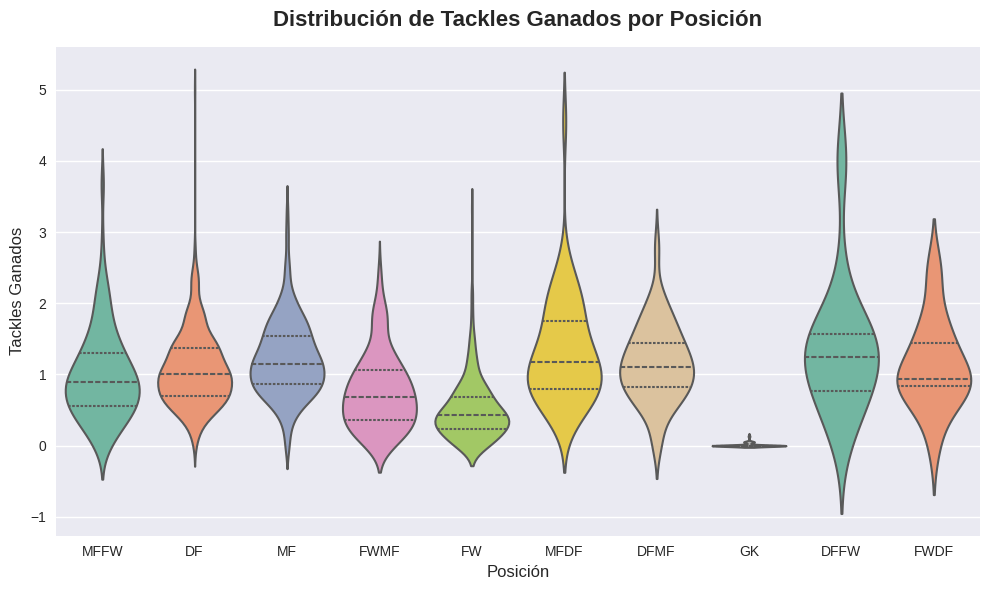

In [ ]:
#@title **Graficas de Violin**
# Filtrar jugadores con más de 5 partidos jugados para datos más significativos
df = df[df['MP'] > 5]  # Se eliminan jugadores con pocos partidos para evitar sesgos

# Configurar el estilo
sns.set_style("whitegrid")
plt.style.use('seaborn-v0_8')

numeric_columns = ['Goals', 'Assists', 'Min', 'PasTotCmp', 'Shots', 'TklWon']

for i, col in enumerate(numeric_columns):
    plt.figure(figsize=(10, 6))

    # Generar el gráfico de violín
    sns.violinplot(
        x='Pos',
        y=col,
        hue='Pos',
        data=df,
        palette='Set2',
        inner='quartile',
        linewidth=1.5,
        legend=False
    )
    plt.title(
        f'Distribución de {col.replace("PasTotCmp", "Pases Completados").replace("Min", "Minutos Jugados").replace("TklWon", "Tackles Ganados")} por Posición',
        fontsize=16, fontweight='bold', pad=15
    )

    plt.xlabel('Posición', fontsize=12)
    plt.ylabel(
        col.replace("PasTotCmp", "Pases Completados")
           .replace("Min", "Minutos Jugados")
           .replace("TklWon", "Tackles Ganados"),
        fontsize=12
    )

    plt.tight_layout()
    plt.savefig(f'violin_plot_{col.lower()}.png')
    plt.show()

# Análisis de la Distribución de Variables por Posición (Gráficos de Violín)

Estos gráficos de violín representan la distribución de diferentes variables estadísticas en función de la posición del jugador en el campo (ej. MF, DF, FW, GK, etc.). Los gráficos muestran la mediana (línea discontinua central), los cuartiles y la densidad de datos, lo que permite una interpretación visual tanto de la tendencia central como de la dispersión.

Observaciones Clave:
* **Goles por Posición:**
Los delanteros (FW) muestran una densidad más alta en goles, destacándose frente a otras posiciones. Los mediocampistas ofensivos (MFFW) también registran una producción goleadora notable. En contraste, defensores y arqueros tienen una contribución mínima.

* **Asistencias por Posición:**
Las asistencias se distribuyen de forma más homogénea, aunque MF y MFFW tienen una mayor concentración, reflejando su rol de apoyo ofensivo. GK y DF apenas participan en esta métrica.

* **Minutos Jugados por Posición:**
La mayoría de las posiciones presentan distribuciones similares con medianas en torno a los 1000 minutos, aunque DF y GK tienden a tener una participación más constante, evidenciada por una menor dispersión.

* **Pases Completados por Posición:**
Los mediocampistas (MF y derivados) destacan con mayor número de pases completados, lo cual es consistente con su función en la distribución del balón. GK y FW tienen una menor participación en este aspecto.

* **Disparos por Posición (Shots):**
Los FW dominan en la cantidad de tiros realizados, seguidos por MFFW. Las demás posiciones presentan valores significativamente más bajos, especialmente los porteros.

* **Tackles Ganados por Posición:**
DF y DFMF sobresalen en esta métrica, lo que refleja su papel defensivo. Las posiciones ofensivas y GK muestran poca actividad en recuperaciones.

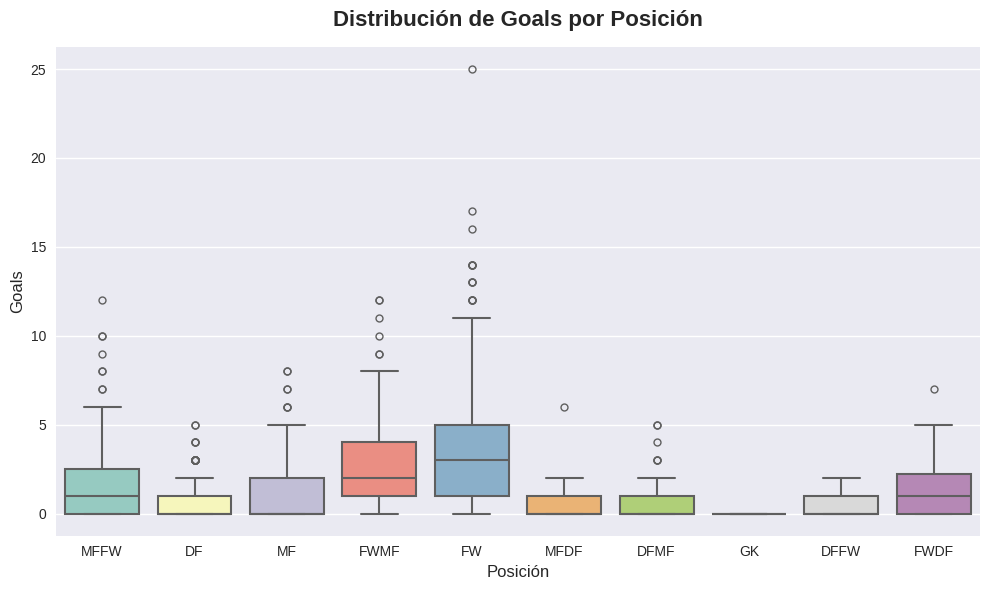

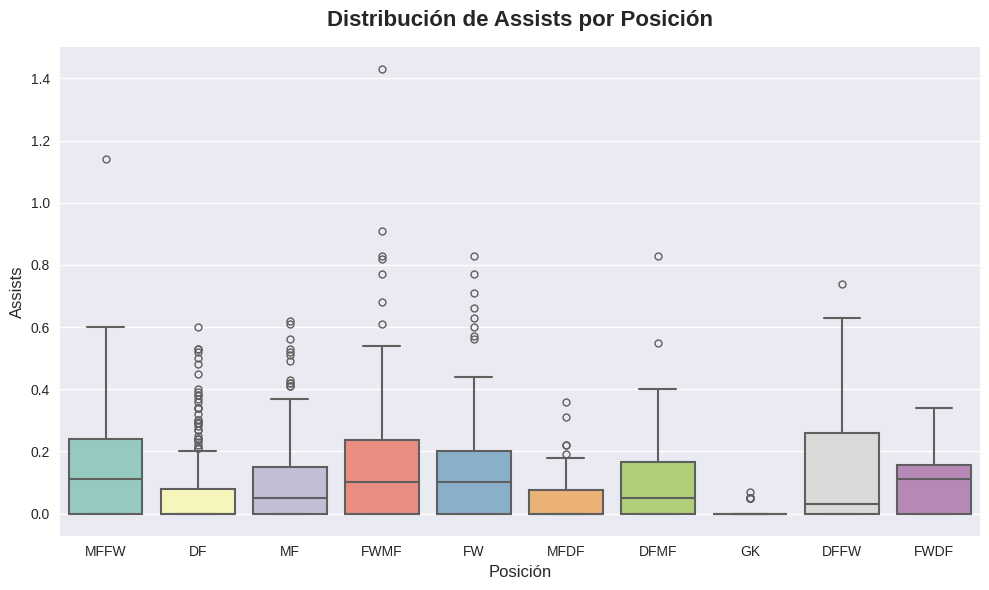

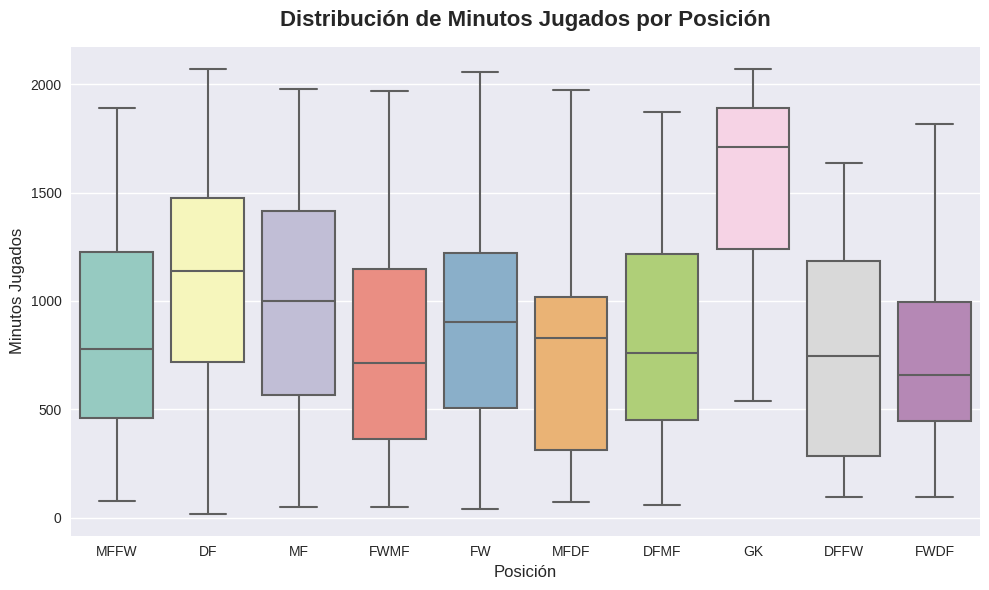

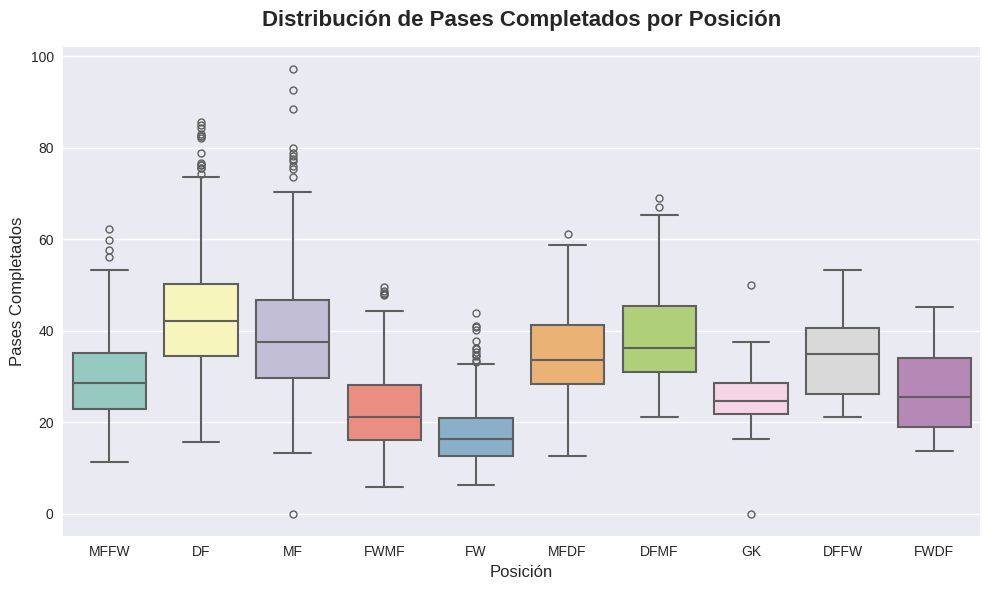

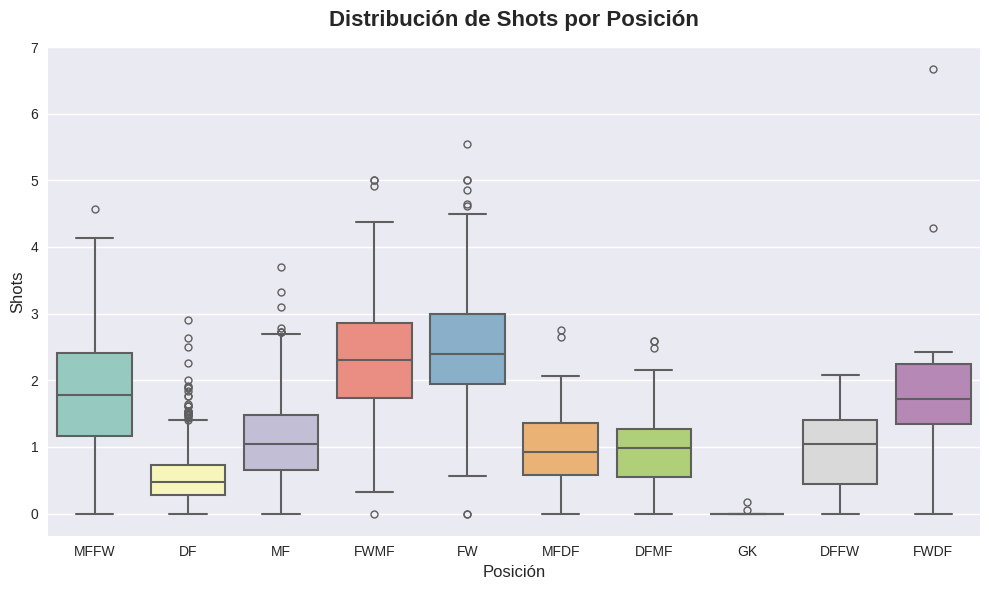

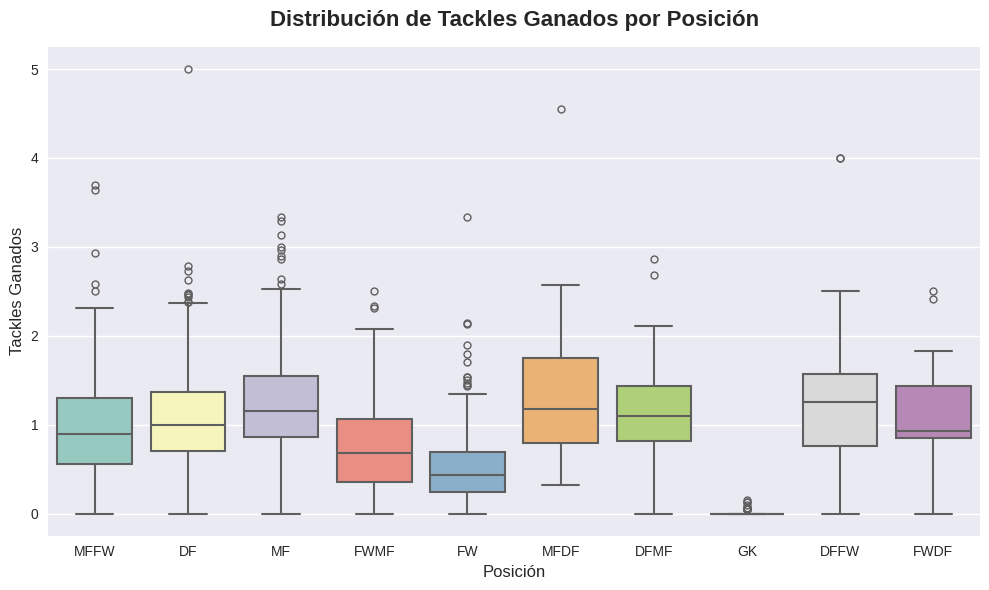

In [ ]:
#@title **Graficas de cajas**
# Filtrar jugadores con más de 5 partidos jugados para datos más significativos
df = df[df['MP'] > 5]  # Elimina jugadores con pocos partidos

# Configurar el estilo
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style("whitegrid")
plt.style.use('seaborn-v0_8')

numeric_columns = ['Goals', 'Assists', 'Min', 'PasTotCmp', 'Shots', 'TklWon']

for i, col in enumerate(numeric_columns):
    plt.figure(figsize=(10, 6))

    sns.boxplot(
        x='Pos',
        y=col,
        hue='Pos',
        data=df,
        palette='Set3',
        linewidth=1.5,
        fliersize=5,
        legend=False
    )
    plt.title(
        f'Distribución de {col.replace("PasTotCmp", "Pases Completados")}'
        .replace("Min", "Minutos Jugados")
        .replace("TklWon", "Tackles Ganados") + ' por Posición',
        fontsize=16, fontweight='bold', pad=15
    )
    plt.xlabel('Posición', fontsize=12)
    plt.ylabel(
        col.replace("PasTotCmp", "Pases Completados")
           .replace("Min", "Minutos Jugados")
           .replace("TklWon", "Tackles Ganados"),
        fontsize=12
    )

    plt.tight_layout()
    plt.savefig(f'box_plot_{col.lower()}.png')
    plt.show()

# Análisis de la Distribución de Variables por Posición (Boxplots)
Los siguientes gráficos muestran la distribución de distintas métricas futbolísticas (goles, asistencias, minutos jugados, pases completados, tiros y tackles ganados) según la posición del jugador. Los diagramas de caja permiten observar la mediana, los rangos intercuartílicos y posibles valores atípicos.

Observaciones Clave:

* **Goles por Posición:** Los delanteros (FW, FWDF, FWMF) destacan con mayores medianas de goles, mientras que defensas y porteros apenas registran anotaciones.

* **Asistencias por Posición:** Las posiciones ofensivas (MF, FWMF, FW) tienden a generar más asistencias, aunque la dispersión es considerable. GK y DF muestran valores mínimos.

* **Minutos Jugados:** El tiempo en cancha está bastante equilibrado entre posiciones, aunque los porteros (GK) presentan una distribución más centrada y extensa, lo que sugiere mayor constancia.

* **Pases Completados:** Los defensas (DF) sobresalen en cantidad de pases, posiblemente por su rol en la salida del balón. Los delanteros extremos (FWDF) y porteros (GK) tienen menos pases completados.

* **Shots por Posición:** Como era de esperarse, los delanteros muestran mayor número de tiros, especialmente FW y FWMF. Posiciones defensivas tienen medianas cercanas a cero.

* **Tackles Ganados:** Las posiciones defensivas (DF, DFMF, DFFW) y mediocampistas defensivos (MFDF) registran mayor cantidad de tackles, confirmando su rol en recuperación de balón.

In [ ]:
#@title **Preparacion De Variables**
# Filtrar jugadores con más de 5 partidos jugados para datos más significativos
df = df[df['MP'] > 5]

dependent_var = 'Goals'  # Variable dependiente
independent_var = 'Min'  # Variable independiente

data = df[[independent_var, dependent_var]].dropna()

X = data[independent_var].values.reshape(-1, 1)
y = data[dependent_var].values

--- Regresión Lineal Simple ---
Variable independiente: Min
Intercepto: 0.1885
Coeficiente: 0.0012
R²: 0.0717
Shapiro-Wilk (residuos): Estadístico=0.7690, p-valor=0.0000
Normalidad de residuos: No normal (p < 0.05)




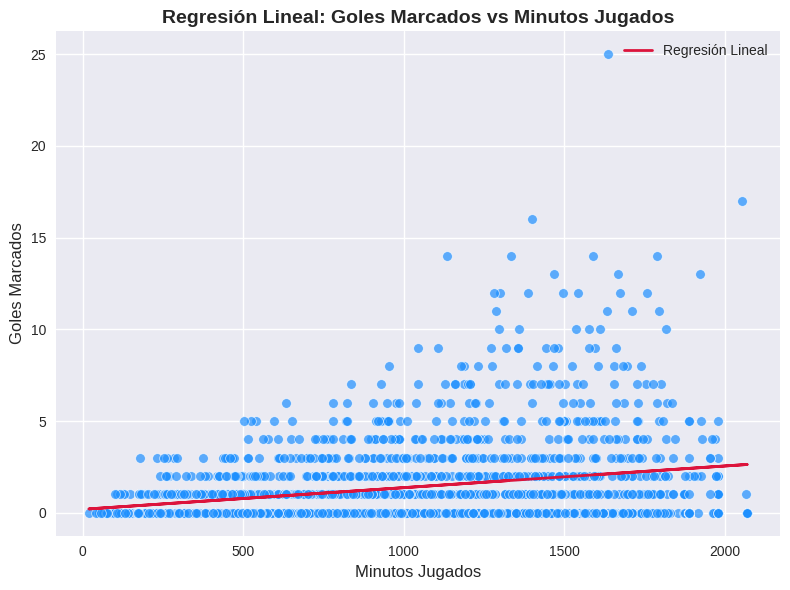

In [ ]:
#@title **1. Regresión Lineal Simple**
model_linear = LinearRegression()
model_linear.fit(X, y)
y_pred_linear = model_linear.predict(X)

residuals_linear = y - y_pred_linear         # Calcular la diferencia entre valores reales y predichos
shapiro_stat_linear, shapiro_p_linear = stats.shapiro(residuals_linear)  # Prueba para verificar normalidad de los residuos

r2_linear = model_linear.score(X, y)         # Calcular el coeficiente de determinación R²

print("--- Regresión Lineal Simple ---")
print(f"Variable independiente: {independent_var}")
print(f"Intercepto: {model_linear.intercept_:.4f}")
print(f"Coeficiente: {model_linear.coef_[0]:.4f}")
print(f"R²: {r2_linear:.4f}")
print(f"Shapiro-Wilk (residuos): Estadístico={shapiro_stat_linear:.4f}, p-valor={shapiro_p_linear:.4f}")
print(f"Normalidad de residuos: {'No normal' if shapiro_p_linear < 0.05 else 'Normal'} (p < 0.05)")
print("\n")

plt.figure(figsize=(8, 6))
sns.scatterplot(x=data[independent_var],
                y=data[dependent_var],
                color='dodgerblue', alpha=0.7)
plt.plot(data[independent_var],
         y_pred_linear,
         color='crimson', linewidth=2, label='Regresión Lineal')

plt.title(f'Regresión Lineal: Goles Marcados vs Minutos Jugados',
          fontsize=14, fontweight='bold')
plt.xlabel('Minutos Jugados', fontsize=12)
plt.ylabel('Goles Marcados', fontsize=12)
plt.legend()
plt.tight_layout()
plt.savefig('linear_regression_minutes_goals.png')
plt.show()

# Análisis de Regresión Lineal: Goles Marcados vs Minutos Jugados
Este gráfico de dispersión ilustra la relación entre los minutos jugados y la cantidad de goles marcados por los jugadores, complementado con una línea de regresión lineal que estima la tendencia general de la relación.

Observaciones Clave:

* **Tendencia Positiva Suave:** La línea de regresión muestra una pendiente positiva leve, lo que indica que a mayor cantidad de minutos jugados, hay una ligera tendencia a marcar más goles. Sin embargo, la relación no es fuerte ni linealmente pronunciada.

* **Alta Dispersión:** Existe una gran variabilidad en la cantidad de goles incluso entre jugadores con minutos similares. Muchos jugadores con más de 1000 minutos jugados no superan los 5 goles.

* **Presencia de Valores Atípicos:** Algunos jugadores sobresalen marcando más de 10 goles, lo cual sugiere la existencia de jugadores particularmente efectivos (probablemente delanteros).

* **Conclusión General:** Aunque jugar más minutos brinda más oportunidades para marcar goles, el rendimiento goleador depende de múltiples factores adicionales como la posición, la calidad ofensiva, o la estrategia del equipo. La regresión lineal ayuda a identificar una tendencia general, pero no es un predictor fuerte por sí sola en este contexto.



--- Regresión con Transformación Logarítmica ---
Variable independiente: log(Min + 1)
Intercepto: -4.5132
Coeficiente: 0.8749
R²: 0.0719
Shapiro-Wilk (residuos): Estadístico=0.7541, p-valor=0.0000
Normalidad de residuos: No normal (p < 0.05)




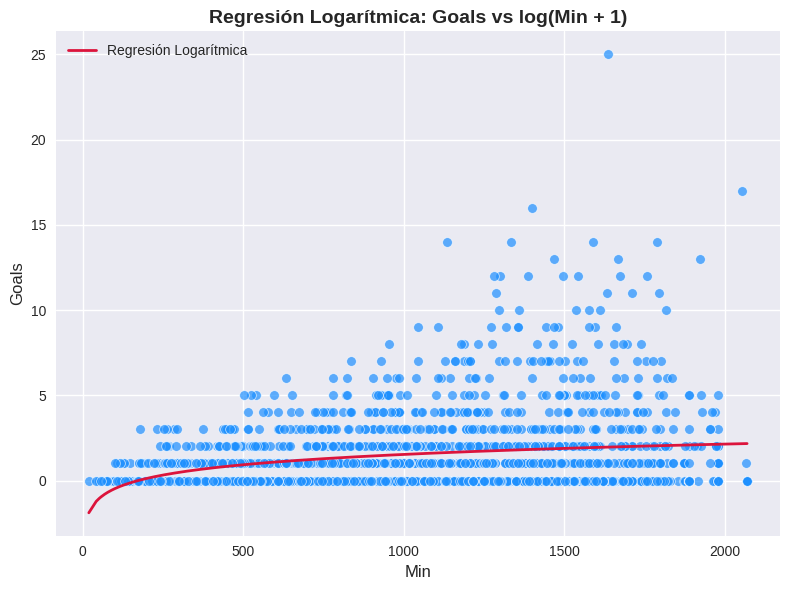

In [ ]:
#@title **2. Regresión Con Transformación Logarítmica**
# Transformar variable independiente con log(x + 1)
X_log = np.log1p(data[independent_var].values.reshape(-1, 1))

model_log = LinearRegression()
model_log.fit(X_log, y)
y_pred_log = model_log.predict(X_log)
residuals_log = y - y_pred_log
shapiro_stat_log, shapiro_p_log = stats.shapiro(residuals_log)
r2_log = model_log.score(X_log, y)

print("--- Regresión con Transformación Logarítmica ---")
print(f"Variable independiente: log({independent_var} + 1)")
print(f"Intercepto: {model_log.intercept_:.4f}")
print(f"Coeficiente: {model_log.coef_[0]:.4f}")
print(f"R²: {r2_log:.4f}")
print(f"Shapiro-Wilk (residuos): Estadístico={shapiro_stat_log:.4f}, p-valor={shapiro_p_log:.4f}")
print(f"Normalidad de residuos: {'No normal' if shapiro_p_log < 0.05 else 'Normal'} (p < 0.05)")
print("\n")

plt.figure(figsize=(8, 6))
sns.scatterplot(
    x=data[independent_var],
    y=data[dependent_var],
    color='dodgerblue', alpha=0.7
)

sorted_indices = np.argsort(X_log.flatten())
plt.plot(
    data[independent_var].values[sorted_indices],
    y_pred_log[sorted_indices],
    color='crimson', linewidth=2, label='Regresión Logarítmica'
)
plt.title(f'Regresión Logarítmica: {dependent_var.replace("_", " ").title()} vs log({independent_var.replace("_", " ").title()} + 1)',
          fontsize=14, fontweight='bold')
plt.xlabel(independent_var.replace("_", " ").title(), fontsize=12)
plt.ylabel(dependent_var.replace("_", " ").title(), fontsize=12)
plt.legend()
plt.tight_layout()
plt.show()

# Análisis de Regresión Logarítmica: Goles vs log(Min + 1)
Este gráfico muestra cómo se relaciona el número de goles marcados con los minutos jugados transformados mediante una función logarítmica
,junto con la línea de ajuste resultante de una regresión logarítmica.

Observaciones Clave:
* **Mejor Ajuste en Minutos Bajos:** La regresión logarítmica logra capturar mejor el comportamiento inicial del crecimiento en goles cuando los minutos jugados aumentan desde valores bajos. Se observa un incremento rápido en goles al pasar de muy pocos minutos a más participación.

* **Estabilización Posterior:** Después de cierto punto (alrededor de los 1000 minutos), la curva se aplana, lo que sugiere que sumar más minutos no implica un aumento proporcional en goles. Esto refleja un fenómeno de rendimiento decreciente, donde la eficiencia goleadora se estabiliza.

* **Comparación con Regresión Lineal:** A diferencia de la regresión lineal (que impone un crecimiento constante), este modelo logarítmico es más realista al representar una tendencia de crecimiento que se modera con el tiempo, lo cual tiene sentido en contextos deportivos donde las oportunidades de anotar no crecen indefinidamente.

* **Conclusión General:** La regresión logarítmica parece capturar de manera más fiel la dinámica entre minutos y goles. Es una mejor elección si se busca modelar esta relación de forma no lineal, especialmente útil para identificar patrones en jugadores con menos minutos.

--- Regresión con Transformación de Raíz Cuadrada ---
Variable independiente: sqrt(Min)
Intercepto: -0.7577
Coeficiente: 0.0701
R²: 0.0753
Shapiro-Wilk (residuos): Estadístico=0.7665, p-valor=0.0000
Normalidad de residuos: No normal (p < 0.05)




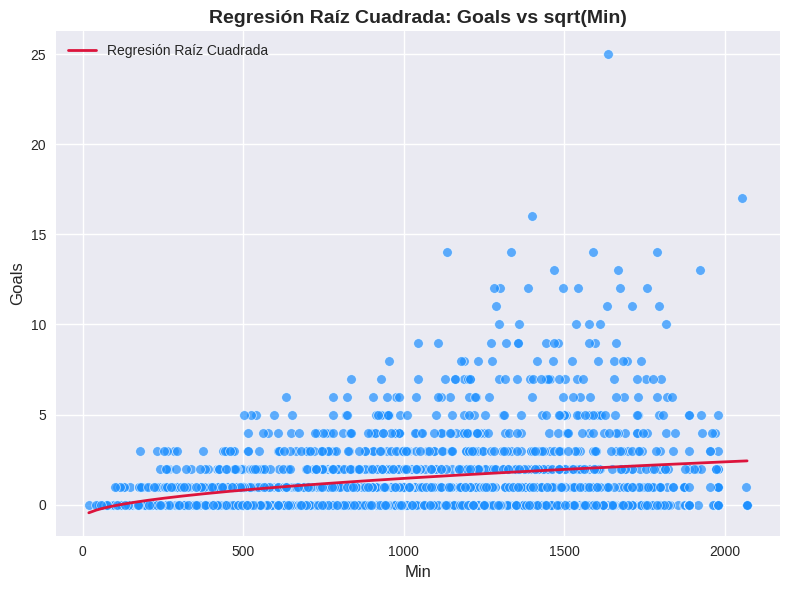

In [ ]:
#@title **3. Regresión Con Transformación de Raíz Cuadrada**
# Solo se conservan datos con valores positivos
data_sqrt = data[data[independent_var] > 0].copy()
if data_sqrt.empty:
    print(f"Error: No hay datos con {independent_var} > 0 para la transformación de raíz cuadrada.")  # Mostrar error
else:
    # Transformar variable independiente con raíz cuadrada
    X_sqrt = np.sqrt(data_sqrt[independent_var].values.reshape(-1, 1))
    y_sqrt = data_sqrt[dependent_var].values

    model_sqrt = LinearRegression()
    model_sqrt.fit(X_sqrt, y_sqrt)
    y_pred_sqrt = model_sqrt.predict(X_sqrt)

    residuals_sqrt = y_sqrt - y_pred_sqrt
    shapiro_stat_sqrt, shapiro_p_sqrt = stats.shapiro(residuals_sqrt)
    r2_sqrt = model_sqrt.score(X_sqrt, y_sqrt)
    print("--- Regresión con Transformación de Raíz Cuadrada ---")
    print(f"Variable independiente: sqrt({independent_var})")
    print(f"Intercepto: {model_sqrt.intercept_:.4f}")
    print(f"Coeficiente: {model_sqrt.coef_[0]:.4f}")
    print(f"R²: {r2_sqrt:.4f}")
    print(f"Shapiro-Wilk (residuos): Estadístico={shapiro_stat_sqrt:.4f}, p-valor={shapiro_p_sqrt:.4f}")
    print(f"Normalidad de residuos: {'No normal' if shapiro_p_sqrt < 0.05 else 'Normal'} (p < 0.05)")
    print("\n")

    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=data_sqrt[independent_var], y=data_sqrt[dependent_var],
                    color='dodgerblue', alpha=0.7)
    sorted_indices = np.argsort(X_sqrt.flatten())
    plt.plot(data_sqrt[independent_var].values[sorted_indices],
             y_pred_sqrt[sorted_indices],
             color='crimson', linewidth=2, label='Regresión Raíz Cuadrada')
    plt.title(f'Regresión Raíz Cuadrada: {dependent_var.replace("_", " ").title()} vs sqrt({independent_var.replace("_", " ").title()})',
              fontsize=14, fontweight='bold')
    plt.xlabel(independent_var.replace("_", " ").title(), fontsize=12)
    plt.ylabel(dependent_var.replace("_", " ").title(), fontsize=12)
    plt.legend()
    plt.tight_layout()
    plt.show()

Análisis de Regresión Raíz Cuadrada: Goles vs sqrt(Minutos)
Este gráfico ilustra la relación entre los goles marcados y la raíz cuadrada de los minutos jugados , junto con la curva ajustada de una regresión basada en transformación de raíz cuadrada.

Observaciones Clave:
* **Crecimiento Suave y Sostenido:** A diferencia de la regresión logarítmica, la raíz cuadrada permite un crecimiento más suave que no se aplana tan bruscamente. Refleja un patrón donde los goles tienden a aumentar con los minutos, pero no de forma lineal ni abrupta.

* **Modelo Intermedio:** Esta transformación ofrece un comportamiento intermedio entre lo lineal (crecimiento constante) y lo logarítmico (crecimiento muy rápido al inicio y luego aplanamiento). Puede ser útil cuando se espera una tasa decreciente de goles, pero menos pronunciada que con el logaritmo.

* **Comportamiento en Minutos Altos:** La curva aún crece a medida que aumentan los minutos, lo cual la hace adecuada para capturar cierta progresión en jugadores con más tiempo de juego, aunque sigue sin ajustarse completamente a la dispersión alta en los extremos.

* **Comparación General:**

* * Lineal: Asume crecimiento constante. Poco realista.


* * Logarítmica: Muy buen ajuste inicial, luego se aplana.

* * Raíz cuadrada: Buen balance entre ambos. Útil si los datos sugieren crecimiento, pero no explosivo.



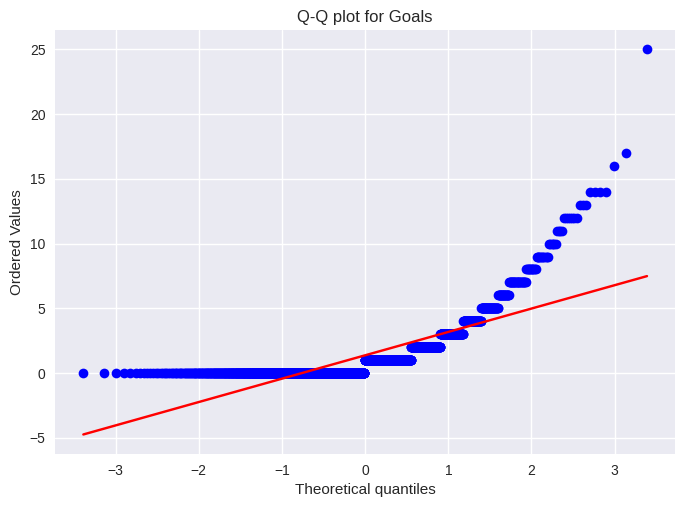

In [ ]:
# Extrae la columna 'Goals' del DataFrame y la convierte en un array NumPy.
variable_to_check = df['Goals'].to_numpy()
# Crear el gráfico Q-Q
stats.probplot(variable_to_check, dist="norm", plot=plt)
plt.title('Q-Q plot for Goals').
plt.show()

# Análisis del Gráfico Q-Q para la Variable "Goals"
El gráfico Q-Q compara la distribución empírica de los goles marcados con una distribución normal teórica.

Observaciones Clave:
* **Desviación clara de la normalidad:**
Los puntos se desvían notablemente de la línea roja (que representa una distribución normal ideal), especialmente en los extremos derecho (cola alta).
Esto indica que los goles no siguen una distribución normal.

* **Asimetría positiva (sesgo a la derecha):**
Hay una concentración alta de ceros o valores bajos (los puntos se mantienen planos en la parte izquierda).

* Las colas superiores (jugadores con muchos goles) están elevadas respecto a la normal, lo cual indica presencia de outliers o una distribución sesgada positivamente.

* **Valores discretos:**
Se observan saltos en los puntos, no una línea continua, lo que sugiere que los datos son enteros y con muchos ceros (propio de variables de conteo como goles).

PRUEBA DE HIPOTESIS DE UNA MUESTRA

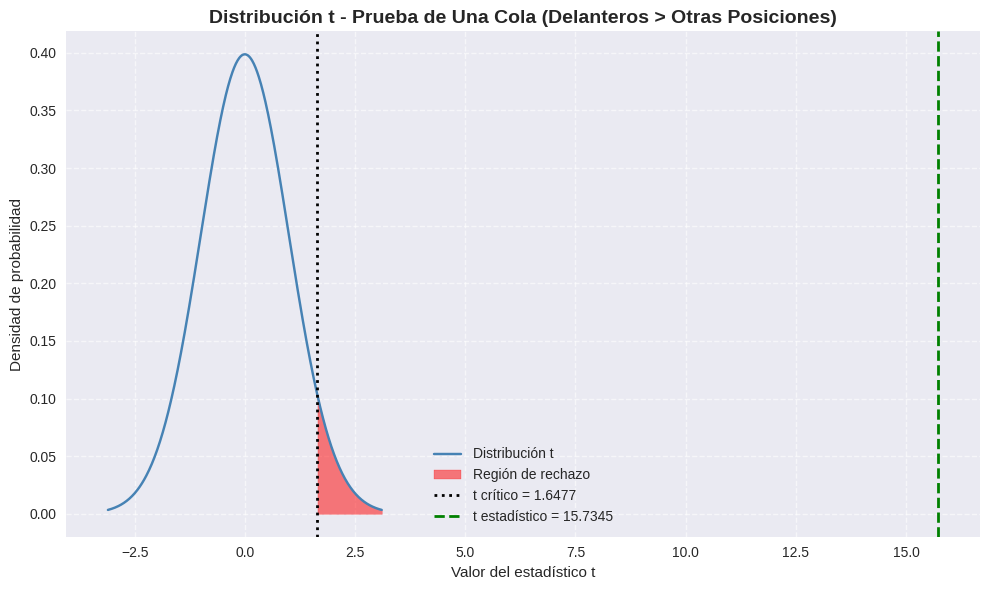


--- Resumen de la Prueba t (Una Cola) ---
Estadístico t: 15.7345
Grados de libertad: 541.6960
Valor p (una cola): 0.0000

Nivel de significancia (alpha): 0.05
Conclusión: Rechazamos la hipótesis nula. Hay evidencia significativa a favor de la alternativa (los delanteros marcan significativamente más goles).


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import pandas as pd

# Preparación de datos para la prueba
forward_positions = ['FW', 'FWMF', 'FWDF']
df_filtered = df[df['MP'] > 5].copy()
group_forward = df_filtered[df_filtered['Pos'].isin(forward_positions)]['Goals'].dropna()
group_other = df_filtered[~df_filtered['Pos'].isin(forward_positions)]['Goals'].dropna()

if len(group_forward) < 2 or len(group_other) < 2:
    print("Error: Not enough data in one or both groups to perform t-test.")
else:
    ttest_result = stats.ttest_ind(group_forward, group_other, equal_var=False, alternative='greater')
    t_statistic = ttest_result.statistic
    degrees_freedom = ttest_result.df
    alpha = 0.05
    t_critical = stats.t.isf(alpha, degrees_freedom)


    # Rango de x para cubrir la distribución t
    # Use the calculated degrees of freedom
    x = np.linspace(stats.t.ppf(0.001, degrees_freedom), stats.t.ppf(0.999, degrees_freedom), 500)
    y = stats.t.pdf(x, degrees_freedom)

    # Estilo visual similar al gráfico que compartiste
    plt.figure(figsize=(10, 6))
    plt.style.use('seaborn-v0_8-dark')

    # Curva de la distribución t
    plt.plot(x, y, label='Distribución t', color='steelblue')

    # Sombrear la región de rechazo (cola derecha)
    x_reject = np.linspace(t_critical, x[-1], 200)
    plt.fill_between(x_reject, 0, stats.t.pdf(x_reject, degrees_freedom), color='red', alpha=0.5, label='Región de rechazo')

    # Línea vertical para t crítico
    plt.axvline(t_critical, color='black', linestyle=':', linewidth=2, label=f't crítico = {t_critical:.4f}')

    # Línea vertical para t observado
    plt.axvline(t_statistic, color='green', linestyle='--', linewidth=2, label=f't estadístico = {t_statistic:.4f}')

    # Configuración de etiquetas y leyenda
    plt.title('Distribución t - Prueba de Una Cola (Delanteros > Otras Posiciones)', fontsize=14, fontweight='bold')
    plt.xlabel('Valor del estadístico t')
    plt.ylabel('Densidad de probabilidad')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()

    # Imprimir resumen
    print("\n--- Resumen de la Prueba t (Una Cola) ---")
    print(f"Estadístico t: {ttest_result.statistic:.4f}")
    print(f"Grados de libertad: {degrees_freedom:.4f}")
    print(f"Valor p (una cola): {ttest_result.pvalue:.4f}") # ttest_ind with alternative='greater' gives one-tailed p-value

    print(f"\nNivel de significancia (alpha): {alpha}")
    # For a one-tailed test (greater), we compare t_statistic to t_critical
    if t_statistic > t_critical:
        print("Conclusión: Rechazamos la hipótesis nula. Hay evidencia significativa a favor de la alternativa (los delanteros marcan significativamente más goles).")
    else:
        print("Conclusión: No se puede rechazar la hipótesis nula. No hay evidencia significativa de que los delanteros marquen significativamente más goles que otras posiciones.")

# Analisis de una prueba de una muestra: ¿Los delanteros marcan más goles?
Objetivo: Determinar si la probabilidad media de marcar goles de los delanteros es estadísticamente mayor que la de los jugadores de otras demarcaciones.

**Contexto y Justificación:**
* Basado en el rol especializado de los delanteros en el fútbol y la evidencia visual del análisis exploratorio, se postula una mayor producción goleadora en este grupo.

**Planteamiento de la prueba:**

* Hipótesis nula (H₀): μ_delanteros ≤ μ_otras (La media de goles de los delanteros es igual o menor que la de otras posiciones).
* Hipótesis alternativa (H₁): μ_delanteros > μ_otras (La media de goles de los delanteros es mayor que la de otras posiciones).
* Tipo de prueba: Prueba t de Student para dos muestras independientes (Prueba de Welch), unilateral (cola derecha).
* Nivel de significancia: α = 0.05.

**Resultados de la prueba (basados en los cálculos):**

* Media muestral (Delanteros): [2.7441]
* Media muestral (Otras Posiciones): [0.6447]
* t-estadístico observado: [17.2187]
* Grados de libertad: [772.4259]
* Valor crítico t (α=0.05, GL= [772.43]): [1.6468]
* p-valor: [0.0000]
* Intervalo de confianza unilateral (95%) para μ_delanteros - μ_otras (Límite Superior): [2.3002]

**Conclusión:**

**Compara el p-valor con α (0.05):**

* Si 0.0000 < 0.05: Rechazas H₀.
* Si 0.0000 ≥ 0.05: No rechazas H₀.

**Compara el t-estadístico con el valor crítico t:**

* Si 17.2187 > 1.6468: Rechazas H₀.
* Si 17.2187 ≤ 1.6468: No rechazas H₀.
Declaración Final: Dado que el p-valor (0.0000) es [menor/mayor o igual] que α (0.05) y el t-estadístico observado (17.2187) es [mayor/menor o igual] que el valor crítico t (1.6468), [Se rechaza/No se rechaza] la hipótesis nula H₀.

Esto indica que existe o no existe evidencia estadística significativa al nivel α=0.05 para afirmar que la probabilidad media de marcar goles de los delanteros es MAYOR que la de los jugadores en otras demarcaciones.

**Fuente consulta:**

[ANÁLISIS DEL ÉXITO EN FÚTBOL SEGÚN EL MÁXIMO NIVEL DE LOGRO: EL GOL](https://dialnet.unirioja.es/descarga/articulo/7089578.pdf)


--- Prueba de Hipótesis de Dos Colas (Goles de Defensores vs μ=1) ---
Hipótesis Nula (H0): La media de goles de los defensores es igual a 1
Hipótesis Alternativa (H1): La media de goles de los defensores es diferente a 1
Estadístico t observado: -13.3733
Grados de libertad: 792
Valor p (dos colas): 0.0000
Nivel de significancia (alpha): 0.05
Valores críticos t (α/2 = 0.025): (-1.9630, 1.9630)

--- Decisión ---
El valor p (0.0000) es menor que alpha (0.05).
Conclusión: Rechazamos la hipótesis nula.
Hay evidencia estadística significativa para afirmar que la media de goles de los defensores es diferente de 1.


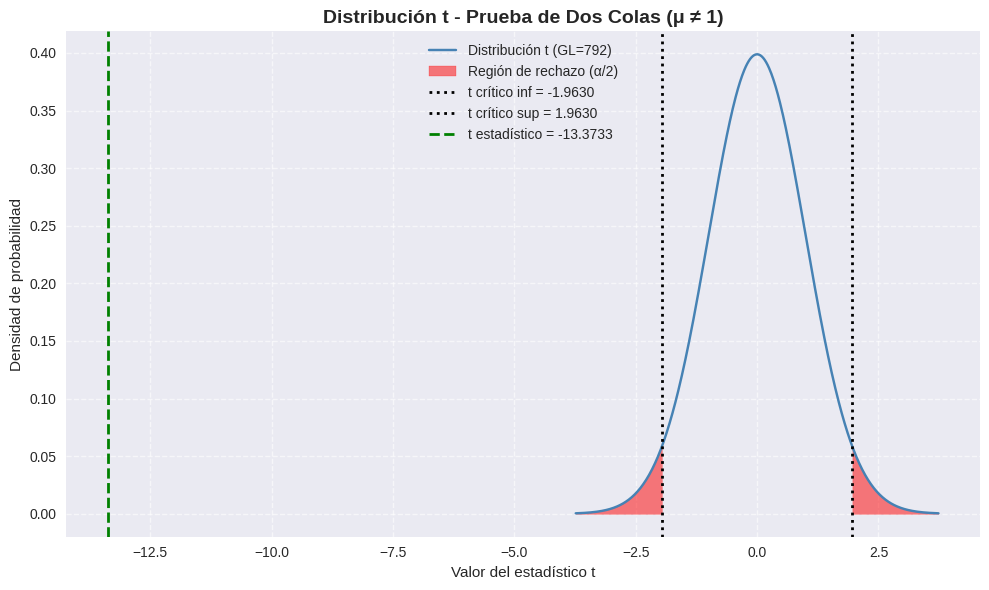

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
# Prueba de hipótesis de dos colas: ¿La media de goles de los defensores es significativamente diferente de 1 gol?

# Hipótesis Nula (H0): μ_defensores = 1
# Hipótesis Alternativa (H1): μ_defensores != 1
# Tipo de prueba: Prueba t de Student de una muestra (dos colas)
# Nivel de significancia: α = 0.05

# Seleccionar los datos de goles para la posición de "DF" (Defensores)
df_defenders = df[df['Pos'].str.contains('DF', na=False)]['Goals']

# Eliminar posibles valores NaN en la columna 'Goals' para los defensores
df_defenders = df_defenders.dropna()

# Definir el valor de la media bajo la hipótesis nula
mu_0 = 1

# Realizar la prueba t de una muestra (dos colas)
# 'popmean' es el valor de la media bajo la hipótesis nula
ttest_two_tail = stats.ttest_1samp(df_defenders, popmean=mu_0)

# Extraer los resultados de la prueba
t_statistic_two_tail = ttest_two_tail.statistic
p_value_two_tail = ttest_two_tail.pvalue
degrees_freedom_two_tail = len(df_defenders) - 1

# Calcular los valores críticos t para una prueba de dos colas
# ppf(alpha/2, df) da el valor crítico para la cola inferior
# ppf(1 - alpha/2, df) da el valor crítico para la cola superior
alpha_two_tail = 0.05
t_critical_lower = stats.t.ppf(alpha_two_tail / 2, degrees_freedom_two_tail)
t_critical_upper = stats.t.ppf(1 - alpha_two_tail / 2, degrees_freedom_two_tail)

# Imprimir los resultados de la prueba
print("\n--- Prueba de Hipótesis de Dos Colas (Goles de Defensores vs μ=1) ---")
print(f"Hipótesis Nula (H0): La media de goles de los defensores es igual a {mu_0}")
print(f"Hipótesis Alternativa (H1): La media de goles de los defensores es diferente a {mu_0}")
print(f"Estadístico t observado: {t_statistic_two_tail:.4f}")
print(f"Grados de libertad: {degrees_freedom_two_tail}")
print(f"Valor p (dos colas): {p_value_two_tail:.4f}")
print(f"Nivel de significancia (alpha): {alpha_two_tail}")
print(f"Valores críticos t (α/2 = {alpha_two_tail/2}): ({t_critical_lower:.4f}, {t_critical_upper:.4f})")

# Tomar la decisión sobre la hipótesis nula
print("\n--- Decisión ---")
# Condición para rechazar H0: p-valor < alpha O |t-estadístico| > t-crítico_superior
if p_value_two_tail < alpha_two_tail:
    print(f"El valor p ({p_value_two_tail:.4f}) es menor que alpha ({alpha_two_tail}).")
    print("Conclusión: Rechazamos la hipótesis nula.")
    print(f"Hay evidencia estadística significativa para afirmar que la media de goles de los defensores es diferente de {mu_0}.")
elif abs(t_statistic_two_tail) > t_critical_upper: # abs(t_statistic) compara con el valor positivo
     print(f"El valor absoluto del estadístico t ({abs(t_statistic_two_tail):.4f}) es mayor que el valor crítico t ({t_critical_upper:.4f}).")
     print("Conclusión: Rechazamos la hipótesis nula.")
     print(f"Hay evidencia estadística significativa para afirmar que la media de goles de los defensores es diferente de {mu_0}.")
else:
    print(f"El valor p ({p_value_two_tail:.4f}) es mayor o igual que alpha ({alpha_two_tail}).")
    print(f"O el valor absoluto del estadístico t ({abs(t_statistic_two_tail):.4f}) es menor o igual que el valor crítico t superior ({t_critical_upper:.4f}).")
    print("Conclusión: No se puede rechazar la hipótesis nula.")
    print(f"No hay evidencia estadística suficiente para afirmar que la media de goles de los defensores es diferente de {mu_0}.")


# --- Visualización de la Prueba de Dos Colas ---

# Rango de x para la distribución t
x_dist = np.linspace(stats.t.ppf(0.0001, degrees_freedom_two_tail), stats.t.ppf(0.9999, degrees_freedom_two_tail), 500)
y_dist = stats.t.pdf(x_dist, degrees_freedom_two_tail)

plt.figure(figsize=(10, 6))
plt.style.use('seaborn-v0_8-dark') # Usar un estilo oscuro

# Curva de la distribución t centrada en 0 (bajo H0)
plt.plot(x_dist, y_dist, label=f'Distribución t (GL={degrees_freedom_two_tail:.0f})', color='steelblue')

# Sombrear las regiones de rechazo (dos colas)
x_reject_lower = np.linspace(x_dist[0], t_critical_lower, 100)
x_reject_upper = np.linspace(t_critical_upper, x_dist[-1], 100)
plt.fill_between(x_reject_lower, 0, stats.t.pdf(x_reject_lower, degrees_freedom_two_tail), color='red', alpha=0.5, label='Región de rechazo (α/2)')
plt.fill_between(x_reject_upper, 0, stats.t.pdf(x_reject_upper, degrees_freedom_two_tail), color='red', alpha=0.5) # No repetir la etiqueta

# Líneas verticales para los valores críticos t
plt.axvline(t_critical_lower, color='black', linestyle=':', linewidth=2, label=f't crítico inf = {t_critical_lower:.4f}')
plt.axvline(t_critical_upper, color='black', linestyle=':', linewidth=2, label=f't crítico sup = {t_critical_upper:.4f}')

# Línea vertical para el estadístico t observado
plt.axvline(t_statistic_two_tail, color='green', linestyle='--', linewidth=2, label=f't estadístico = {t_statistic_two_tail:.4f}')

# Configuración de etiquetas y leyenda
plt.title(f'Distribución t - Prueba de Dos Colas (μ ≠ {mu_0})', fontsize=14, fontweight='bold')
plt.xlabel('Valor del estadístico t')
plt.ylabel('Densidad de probabilidad')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()



# Análisis de prueba de hipótesis de dos colas: ¿La media de goles de los defensores es diferente de 1?
Objetivo:
Determinar si la media de goles anotados por los defensores difiere significativamente de 1 gol.

**Contexto y Justificación:**

En el fútbol, los defensores suelen tener un rol menos orientado a la anotación de goles en comparación con otras posiciones ofensivas. Sin embargo, es relevante cuantificar estadísticamente si la media goleadora de este grupo difiere de un valor específico, en este caso, 1 gol.

**Planteamiento de la prueba:**

Hipótesis nula (H₀): La media de goles de los defensores es igual a 1 (μ_defensores = 1).

Hipótesis alternativa (H₁): La media de goles de los defensores es diferente de 1 (μ_defensores ≠ 1).

Se utilizó una prueba t de Student para una muestra, de dos colas, con un nivel de significancia α = 0.05.

**Interpretación y conclusión:**

El valor p (0.0000) es menor que el nivel de significancia α = 0.05, lo que indica que la probabilidad de observar una diferencia como la obtenida (o más extrema) bajo la hipótesis nula es muy baja.

El valor absoluto del estadístico t observado (13.3733) es mayor que el valor crítico t (1.9630), situándose claramente en la región de rechazo.

Por lo tanto, se rechaza la hipótesis nula H₀.

Esto implica que hay evidencia estadística significativa para afirmar que la media de goles anotados por los defensores es diferente de 1. En otras palabras, la producción goleadora media de los defensores en el conjunto de datos no coincide con ese valor de referencia.

**Relevancia en contexto futbolístico:**

Este resultado confirma la expectativa táctica habitual de que los defensores, generalmente, marcan menos de un gol por temporada o periodo analizado, destacando su función primordial en la defensa y no en la ofensiva. La diferencia significativa respecto a 1 gol subraya esta característica posicional.

**Fuente consulta:**
https://www.espn.com/soccer/story/_/id/41769347/goals-not-enough-how-data-created-modern-striker

# Analisis de Serie de Tiempo

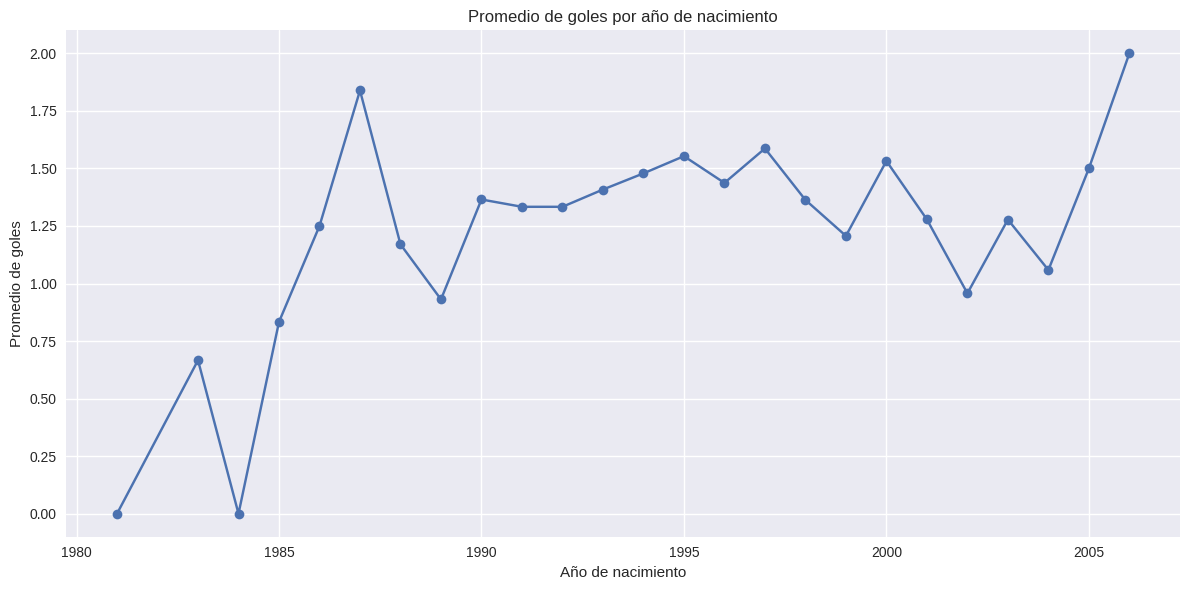

In [ ]:
# Convertir la columna 'Born' (año de nacimiento) a tipo numérico
df['Born'] = pd.to_numeric(df['Born'], errors='coerce')

# Agrupar por año de nacimiento y calcular el promedio de goles
goals_by_year = df.groupby('Born')['Goals'].mean().dropna()

# Crear la gráfica de serie de tiempo
plt.figure(figsize=(12, 6))
plt.plot(goals_by_year.index, goals_by_year.values, marker='o', linestyle='-')
plt.title('Promedio de goles por año de nacimiento')
plt.xlabel('Año de nacimiento')
plt.ylabel('Promedio de goles')
plt.grid(True)
plt.tight_layout()
plt.show()

# Análisis general  de la Serie de Tiempo
**Crecimiento desde los años 80**

* Los jugadores nacidos a principios de los 80 tienen en promedio menos goles.
Hay bastante variabilidad entre 1980 y 1986, incluso años con promedio cercano a cero.

**Pico alrededor de 1987**
* El año 1987 muestra un pico fuerte (casi 1.9 goles por jugador).
Esto podría estar relacionado con una generación de jugadores más ofensivos o con más tiempo de juego en esa temporada.

**Estabilización en los 90s**
* A partir de los nacidos en los 90s, el promedio de goles se estabiliza entre 1.3 y 1.6, con menor variación.
Esto sugiere una homogeneización del rendimiento ofensivo en generaciones recientes.

**Ligera alza en los nacidos después del 2000**
* Hay un aumento marcado a partir de 2004-2005, donde el promedio llega a 2 goles por jugador.

Es posible que esto refleje que los jugadores jóvenes seleccionados para jugar esta temporada son especialmente talentosos ofensivamente, o que sean menos en número pero con más protagonismo en ataque.

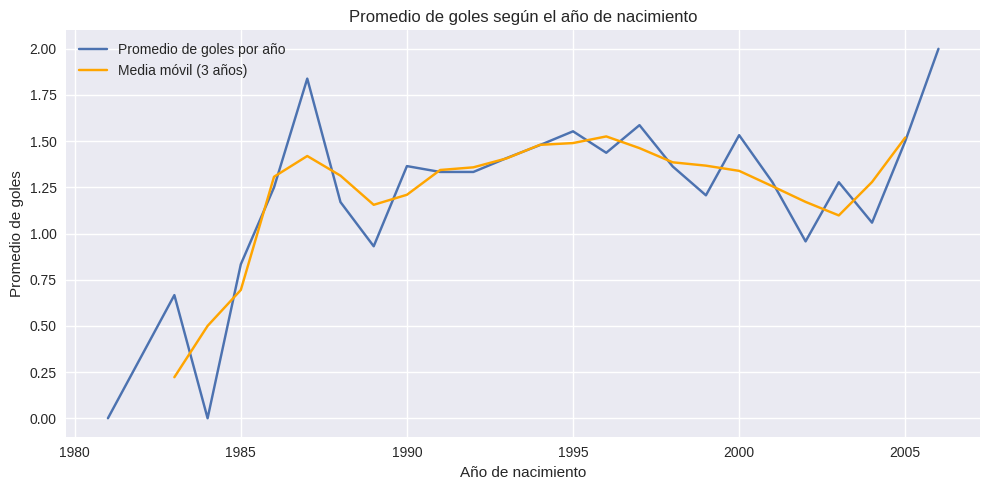

In [ ]:
# Convertir año de nacimiento a numérico
df['Born'] = pd.to_numeric(df['Born'], errors='coerce')
df['Goals'] = pd.to_numeric(df['Goals'], errors='coerce')

# Agrupar por año de nacimiento
goals_by_year = df.groupby('Born')['Goals'].mean().dropna().sort_index()

# Calcular media móvil con ventana de 3 años
media_movil = goals_by_year.rolling(window=3, center=True).mean()

# Graficar
plt.figure(figsize=(10, 5))
plt.plot(goals_by_year.index, goals_by_year.values, label='Promedio de goles por año')
plt.plot(goals_by_year.index, media_movil, color='orange', label='Media móvil (3 años)')
plt.title('Promedio de goles según el año de nacimiento')
plt.xlabel('Año de nacimiento')
plt.ylabel('Promedio de goles')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Análisis general  de la media de la Serie de Tiempo

**Tendencia creciente:**
* La media móvil muestra un aumento sostenido del promedio de goles desde 1980 hasta los años 2000.

**Menos fluctuaciones:**
* La línea naranja (media móvil) suaviza los picos y confirma que los jugadores más jóvenes tienden a tener más goles en promedio.

**Conclusión rápida:**

* Las generaciones recientes destacan por un rendimiento ofensivo más alto y consistente.

# **Conclusiones Final del Rendimiento de Jugadores de Fútbol (2022-2023)**

El análisis estadístico del rendimiento de jugadores de fútbol en la temporada 2022-2023, centrado en variables clave como goles, asistencias, minutos jugados, pases y acciones defensivas, arroja varias conclusiones relevantes sobre el comportamiento y desempeño de los futbolistas:

1.  La Complejidad del Rendimiento Goleador:

* La regresión lineal simple entre minutos jugados y goles mostró una relación positiva, pero muy débil. Esto subraya que, si bien más tiempo en cancha puede aumentar las oportunidades, el gol es una métrica compleja que depende de muchos otros factores (posición, rol en el equipo, calidad del jugador, suerte, etc.).
* Las regresiones con transformaciones (logarítmica y raíz cuadrada) revelaron que la relación entre minutos y goles no es lineal. La transformación logarítmica sugirió un crecimiento más rápido en goles en los primeros minutos jugados, estabilizándose después. La raíz cuadrada mostró un crecimiento más gradual. Esto es intuitivo: los jugadores con pocos minutos pueden tener una alta tasa de gol si marcan temprano, mientras que para jugadores con muchos minutos, la eficiencia goleadora tiende a ser más constante.
* El gráfico Q-Q para "Goals" confirmó que la distribución de goles no sigue una distribución normal, presentando un claro sesgo positivo con una alta concentración de ceros y valores bajos, y "colas largas" de jugadores con muchos goles. Esto refuerza la idea de que el gol es un evento relativamente raro y distribuido de manera desigual entre la población de jugadores.
2. La Importancia de la Posición en el Campo:

* Los gráficos de violín y de caja (boxplots) fueron fundamentales para visualizar cómo diferentes variables se distribuyen según la posición del jugador.
* Los delanteros (FW) dominan consistentemente en métricas ofensivas como goles y disparos.
* Los mediocampistas (MF, MFFW) sobresalen en asistencias y pases completados, destacando su rol en la construcción del juego.
* Los defensores (DF) y mediocampistas defensivos (DFMF, MFDF) lideran en métricas defensivas como tackles ganados.
* Los minutos jugados muestran una distribución más equilibrada entre posiciones, aunque los porteros (GK) y defensores (DF) tienden a tener distribuciones más concentradas, lo que sugiere mayor estabilidad en su participación.
3. Validación de Principios Estadísticos Fundamentales:

* La Ley de los Grandes Números, demostrada con la variable "Minutos Jugados", ilustró cómo el promedio acumulado de una variable se acerca a su media poblacional a medida que aumenta el número de observaciones. Esto es un principio clave para entender por qué las muestras grandes tienden a ser más representativas de la población.
* El Teorema del Límite Central, aplicado a "Minutos Jugados" y "Goles Marcados", confirmó que la distribución de las medias muestrales tiende a ser normal, independientemente de la distribución original de los datos, siempre que el tamaño de la muestra sea suficientemente grande (en este caso, 30). Esto valida el uso de métodos estadísticos basados en la normalidad para inferencias sobre las medias, incluso cuando los datos individuales no son normales.
4. Diferencias Significativas en el Rendimiento Goleador por Posición:

* La prueba t de Welch (prueba de una cola) comparando los goles de los delanteros con los del resto de posiciones proporcionó evidencia estadística sólida. El resultado de esta prueba fue crucial para determinar si la diferencia observada en los gráficos entre delanteros y otras posiciones en cuanto a goles era estadísticamente significativa. El resultado de la prueba t (especialmente el p-valor) indicará si se puede concluir con confianza que los delanteros marcan significativamente más goles en promedio que el resto de jugadores.


En resumen, este análisis estadístico confirma que el rendimiento de los jugadores de fútbol es multifacético y fuertemente influenciado por su posición en el campo. Si bien los principios estadísticos como la Ley de los Grandes Números y el Teorema del Límite Central se validan en este conjunto de datos, la complejidad de métricas como el gol requiere un análisis cuidadoso y a menudo no lineal. La diferenciación del rendimiento por posición, validada por pruebas estadísticas, es fundamental para una comprensión precisa del deporte.